In [1]:
import numpy as np
import pandas as pd
import seaborn as sns

import keras
from keras.models import Sequential
from keras.models import Model
from keras.layers import Dense
from keras.layers import Input
from keras.utils import to_categorical
from keras.callbacks import EarlyStopping, ModelCheckpoint
from keras.models import model_from_json

from keras.regularizers import l1

from sklearn.metrics import confusion_matrix
from sklearn.metrics import precision_score, recall_score, accuracy_score, precision_recall_curve, roc_curve
from sklearn.utils.multiclass import unique_labels
from sklearn.model_selection import train_test_split
from sklearn.ensemble import IsolationForest

import matplotlib.pyplot as plt

import datetime

import plotly as py
import plotly.offline as pyo
import plotly.graph_objs as go
from plotly.graph_objs import Data,Figure

from sklearn.preprocessing import  StandardScaler, MinMaxScaler



Using TensorFlow backend.
/Users/Theo/anaconda3/lib/python3.7/importlib/_bootstrap.py:219: RuntimeWarning: compiletime version 3.6 of module 'tensorflow.python.framework.fast_tensor_util' does not match runtime version 3.7
  return f(*args, **kwds)


In [2]:
# PREPROCESSING

# attach the column names to the dataset
col_names = ["duration","protocol_type","service","flag","src_bytes",
    "dst_bytes","land","wrong_fragment","urgent","hot","num_failed_logins",
    "logged_in","num_compromised","root_shell","su_attempted","num_root",
    "num_file_creations","num_shells","num_access_files","num_outbound_cmds",
    "is_host_login","is_guest_login","count","srv_count","serror_rate",
    "srv_serror_rate","rerror_rate","srv_rerror_rate","same_srv_rate",
    "diff_srv_rate","srv_diff_host_rate","dst_host_count","dst_host_srv_count",
    "dst_host_same_srv_rate","dst_host_diff_srv_rate","dst_host_same_src_port_rate",
    "dst_host_srv_diff_host_rate","dst_host_serror_rate","dst_host_srv_serror_rate",
    "dst_host_rerror_rate","dst_host_srv_rerror_rate","label"]

# open the csv dataset
df = pd.read_csv("kddcup.data_10_percent.gz",compression='gzip',header=None, names = col_names)

# Remove smurf and neptune attacks
df = df[df.label != 'smurf.']
df = df[df.label != 'neptune.']

# Remove duplicates
df.drop_duplicates(subset=None, keep='first', inplace=True)


#data = df.drop("label", axis=1) #labels serviront pour évaluer la qualité du modèle
target = df["label"]



# One hot encoding
cols_to_dummify = ['protocol_type','service','flag']
data_dummy = pd.get_dummies(df, columns=cols_to_dummify, prefix=cols_to_dummify)
target_dummy = pd.get_dummies(target)
target_categories = target_dummy.columns

# Splitting train/test
X = data_dummy.values
y = target_dummy.values
RANDOM_SEED = 87 #penser a changer la seed a posteriori pour voir
X_train, X_test = train_test_split(data_dummy, test_size=0.2, random_state = RANDOM_SEED)

#X_train = X_train[X_train['label'] == 'normal.' ] # Only train on normal data (no intrusion)
# X_test = X_test[X_test['label'] == 'normal.']
y_train = X_train['label'] 
ylabel_train= (y_train != 'normal.')
X_train = X_train.drop(['label'], axis=1)
y_test  = X_test['label']
X_test  = X_test.drop(['label'], axis=1)
X_train = X_train.values
X_test  = X_test.values

# Standardize/Normalize dataset?
scaler = MinMaxScaler()
X_train_scaled = scaler.fit_transform(X_train)
X_test_scaled  = scaler.transform(X_test)

print('Training data size   :', X_train.shape)
print('Validation (test) data size :', X_test.shape)
data_dummy.head()

Training data size   : (74500, 109)
Validation (test) data size : (18625, 109)


,duration,src_bytes,dst_bytes,land,wrong_fragment,urgent,hot,num_failed_logins,logged_in,num_compromised,...,flag_REJ,flag_RSTO,flag_RSTOS0,flag_RSTR,flag_S0,flag_S1,flag_S2,flag_S3,flag_SF,flag_SH
0,0,181,5450,0,0,0,0,0,1,0,...,0,0,0,0,0,0,0,0,1,0
1,0,239,486,0,0,0,0,0,1,0,...,0,0,0,0,0,0,0,0,1,0
2,0,235,1337,0,0,0,0,0,1,0,...,0,0,0,0,0,0,0,0,1,0
3,0,219,1337,0,0,0,0,0,1,0,...,0,0,0,0,0,0,0,0,1,0
4,0,217,2032,0,0,0,0,0,1,0,...,0,0,0,0,0,0,0,0,1,0


/Users/Theo/anaconda3/lib/python3.7/site-packages/sklearn/ensemble/iforest.py:213: FutureWarning:

default contamination parameter 0.1 will change in version 0.22 to "auto". This will change the predict method behavior.

/Users/Theo/anaconda3/lib/python3.7/site-packages/sklearn/ensemble/iforest.py:223: FutureWarning:

behaviour="old" is deprecated and will be removed in version 0.22. Please use behaviour="new", which makes the decision_function change to match other anomaly detection algorithm API.



f1_score= 0.4074623177662466


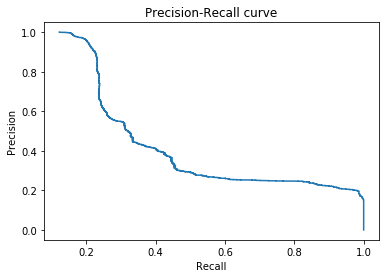

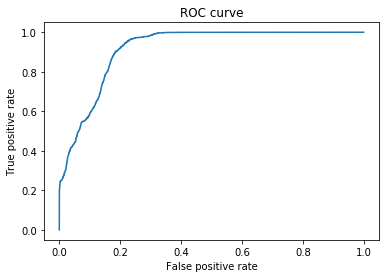

/Users/Theo/anaconda3/lib/python3.7/site-packages/sklearn/ensemble/iforest.py:417: DeprecationWarning:

threshold_ attribute is deprecated in 0.20 and will be removed in 0.22.

/Users/Theo/anaconda3/lib/python3.7/site-packages/sklearn/ensemble/iforest.py:417: DeprecationWarning:

threshold_ attribute is deprecated in 0.20 and will be removed in 0.22.

/Users/Theo/anaconda3/lib/python3.7/site-packages/sklearn/ensemble/iforest.py:213: FutureWarning:

default contamination parameter 0.1 will change in version 0.22 to "auto". This will change the predict method behavior.

/Users/Theo/anaconda3/lib/python3.7/site-packages/sklearn/ensemble/iforest.py:223: FutureWarning:

behaviour="old" is deprecated and will be removed in version 0.22. Please use behaviour="new", which makes the decision_function change to match other anomaly detection algorithm API.



f1_score= 0.5008146384258679


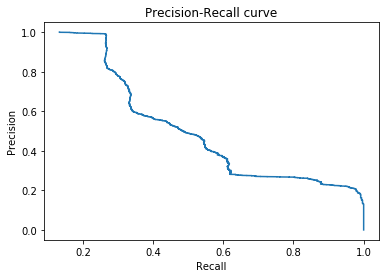

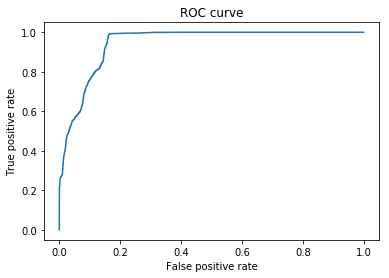

/Users/Theo/anaconda3/lib/python3.7/site-packages/sklearn/ensemble/iforest.py:417: DeprecationWarning:

threshold_ attribute is deprecated in 0.20 and will be removed in 0.22.

/Users/Theo/anaconda3/lib/python3.7/site-packages/sklearn/ensemble/iforest.py:417: DeprecationWarning:

threshold_ attribute is deprecated in 0.20 and will be removed in 0.22.

/Users/Theo/anaconda3/lib/python3.7/site-packages/sklearn/ensemble/iforest.py:213: FutureWarning:

default contamination parameter 0.1 will change in version 0.22 to "auto". This will change the predict method behavior.

/Users/Theo/anaconda3/lib/python3.7/site-packages/sklearn/ensemble/iforest.py:223: FutureWarning:

behaviour="old" is deprecated and will be removed in version 0.22. Please use behaviour="new", which makes the decision_function change to match other anomaly detection algorithm API.



f1_score= 0.5149700598802395


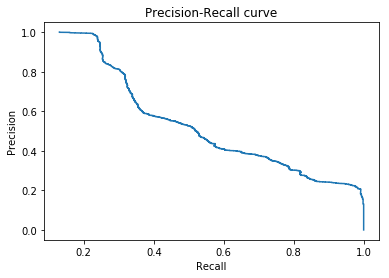

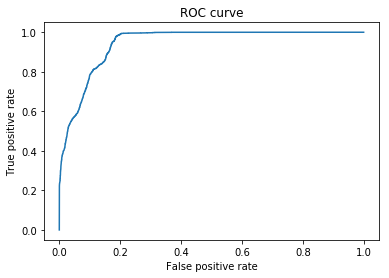

/Users/Theo/anaconda3/lib/python3.7/site-packages/sklearn/ensemble/iforest.py:417: DeprecationWarning:

threshold_ attribute is deprecated in 0.20 and will be removed in 0.22.

/Users/Theo/anaconda3/lib/python3.7/site-packages/sklearn/ensemble/iforest.py:417: DeprecationWarning:

threshold_ attribute is deprecated in 0.20 and will be removed in 0.22.

/Users/Theo/anaconda3/lib/python3.7/site-packages/sklearn/ensemble/iforest.py:213: FutureWarning:

default contamination parameter 0.1 will change in version 0.22 to "auto". This will change the predict method behavior.

/Users/Theo/anaconda3/lib/python3.7/site-packages/sklearn/ensemble/iforest.py:223: FutureWarning:

behaviour="old" is deprecated and will be removed in version 0.22. Please use behaviour="new", which makes the decision_function change to match other anomaly detection algorithm API.



f1_score= 0.5663421418636997


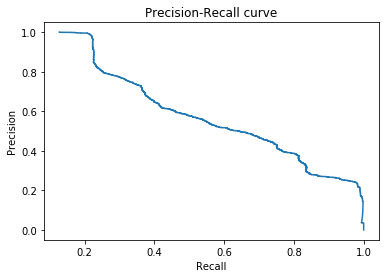

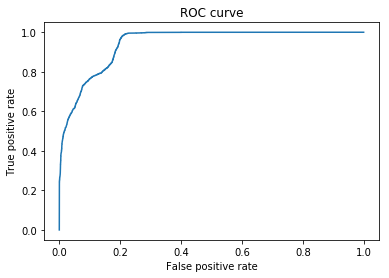

/Users/Theo/anaconda3/lib/python3.7/site-packages/sklearn/ensemble/iforest.py:417: DeprecationWarning:

threshold_ attribute is deprecated in 0.20 and will be removed in 0.22.

/Users/Theo/anaconda3/lib/python3.7/site-packages/sklearn/ensemble/iforest.py:417: DeprecationWarning:

threshold_ attribute is deprecated in 0.20 and will be removed in 0.22.

/Users/Theo/anaconda3/lib/python3.7/site-packages/sklearn/ensemble/iforest.py:213: FutureWarning:

default contamination parameter 0.1 will change in version 0.22 to "auto". This will change the predict method behavior.

/Users/Theo/anaconda3/lib/python3.7/site-packages/sklearn/ensemble/iforest.py:223: FutureWarning:

behaviour="old" is deprecated and will be removed in version 0.22. Please use behaviour="new", which makes the decision_function change to match other anomaly detection algorithm API.



f1_score= 0.5181428893396438


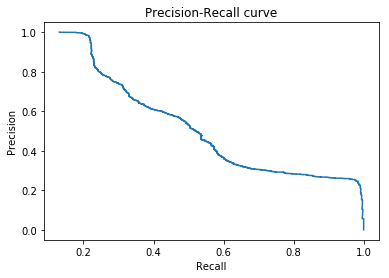

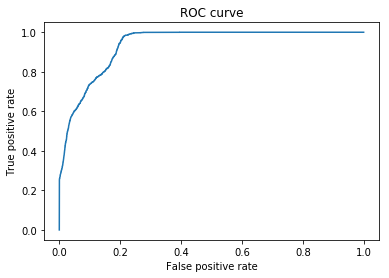

/Users/Theo/anaconda3/lib/python3.7/site-packages/sklearn/ensemble/iforest.py:417: DeprecationWarning:

threshold_ attribute is deprecated in 0.20 and will be removed in 0.22.

/Users/Theo/anaconda3/lib/python3.7/site-packages/sklearn/ensemble/iforest.py:417: DeprecationWarning:

threshold_ attribute is deprecated in 0.20 and will be removed in 0.22.

/Users/Theo/anaconda3/lib/python3.7/site-packages/sklearn/ensemble/iforest.py:213: FutureWarning:

default contamination parameter 0.1 will change in version 0.22 to "auto". This will change the predict method behavior.

/Users/Theo/anaconda3/lib/python3.7/site-packages/sklearn/ensemble/iforest.py:223: FutureWarning:

behaviour="old" is deprecated and will be removed in version 0.22. Please use behaviour="new", which makes the decision_function change to match other anomaly detection algorithm API.



f1_score= 0.5224588897472685


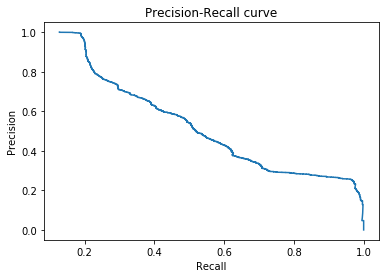

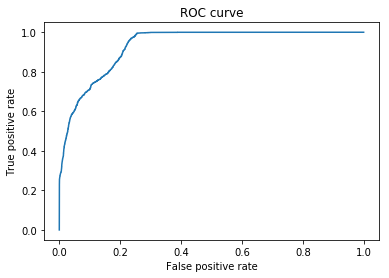

/Users/Theo/anaconda3/lib/python3.7/site-packages/sklearn/ensemble/iforest.py:417: DeprecationWarning:

threshold_ attribute is deprecated in 0.20 and will be removed in 0.22.

/Users/Theo/anaconda3/lib/python3.7/site-packages/sklearn/ensemble/iforest.py:417: DeprecationWarning:

threshold_ attribute is deprecated in 0.20 and will be removed in 0.22.

/Users/Theo/anaconda3/lib/python3.7/site-packages/sklearn/ensemble/iforest.py:213: FutureWarning:

default contamination parameter 0.1 will change in version 0.22 to "auto". This will change the predict method behavior.

/Users/Theo/anaconda3/lib/python3.7/site-packages/sklearn/ensemble/iforest.py:223: FutureWarning:

behaviour="old" is deprecated and will be removed in version 0.22. Please use behaviour="new", which makes the decision_function change to match other anomaly detection algorithm API.



f1_score= 0.5710098197273926


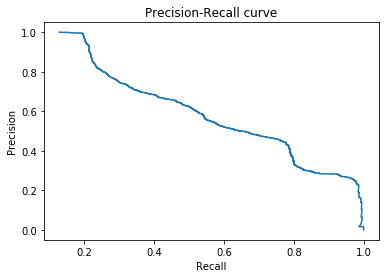

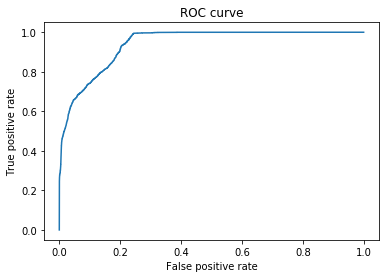

/Users/Theo/anaconda3/lib/python3.7/site-packages/sklearn/ensemble/iforest.py:417: DeprecationWarning:

threshold_ attribute is deprecated in 0.20 and will be removed in 0.22.

/Users/Theo/anaconda3/lib/python3.7/site-packages/sklearn/ensemble/iforest.py:417: DeprecationWarning:

threshold_ attribute is deprecated in 0.20 and will be removed in 0.22.

/Users/Theo/anaconda3/lib/python3.7/site-packages/sklearn/ensemble/iforest.py:213: FutureWarning:

default contamination parameter 0.1 will change in version 0.22 to "auto". This will change the predict method behavior.

/Users/Theo/anaconda3/lib/python3.7/site-packages/sklearn/ensemble/iforest.py:223: FutureWarning:

behaviour="old" is deprecated and will be removed in version 0.22. Please use behaviour="new", which makes the decision_function change to match other anomaly detection algorithm API.



f1_score= 0.5395070260308684


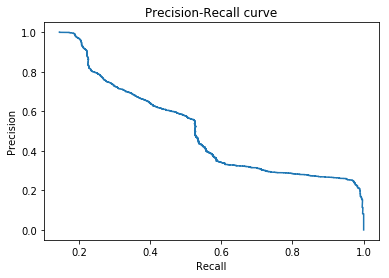

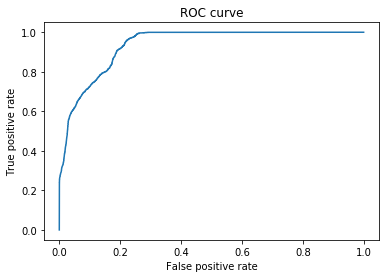

/Users/Theo/anaconda3/lib/python3.7/site-packages/sklearn/ensemble/iforest.py:417: DeprecationWarning:

threshold_ attribute is deprecated in 0.20 and will be removed in 0.22.

/Users/Theo/anaconda3/lib/python3.7/site-packages/sklearn/ensemble/iforest.py:417: DeprecationWarning:

threshold_ attribute is deprecated in 0.20 and will be removed in 0.22.

/Users/Theo/anaconda3/lib/python3.7/site-packages/sklearn/ensemble/iforest.py:213: FutureWarning:

default contamination parameter 0.1 will change in version 0.22 to "auto". This will change the predict method behavior.

/Users/Theo/anaconda3/lib/python3.7/site-packages/sklearn/ensemble/iforest.py:223: FutureWarning:

behaviour="old" is deprecated and will be removed in version 0.22. Please use behaviour="new", which makes the decision_function change to match other anomaly detection algorithm API.



f1_score= 0.5421625470450615


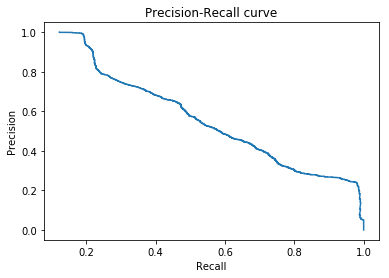

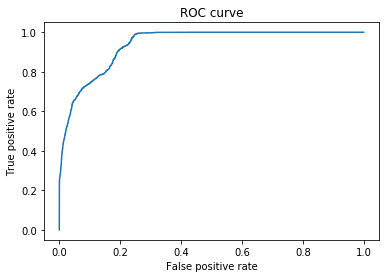

/Users/Theo/anaconda3/lib/python3.7/site-packages/sklearn/ensemble/iforest.py:417: DeprecationWarning:

threshold_ attribute is deprecated in 0.20 and will be removed in 0.22.

/Users/Theo/anaconda3/lib/python3.7/site-packages/sklearn/ensemble/iforest.py:417: DeprecationWarning:

threshold_ attribute is deprecated in 0.20 and will be removed in 0.22.

/Users/Theo/anaconda3/lib/python3.7/site-packages/sklearn/ensemble/iforest.py:213: FutureWarning:

default contamination parameter 0.1 will change in version 0.22 to "auto". This will change the predict method behavior.

/Users/Theo/anaconda3/lib/python3.7/site-packages/sklearn/ensemble/iforest.py:223: FutureWarning:

behaviour="old" is deprecated and will be removed in version 0.22. Please use behaviour="new", which makes the decision_function change to match other anomaly detection algorithm API.



f1_score= 0.5887785084650903


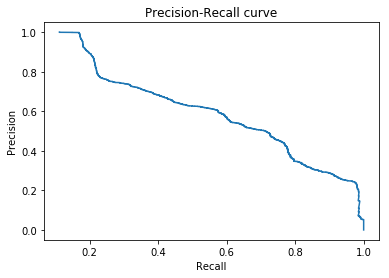

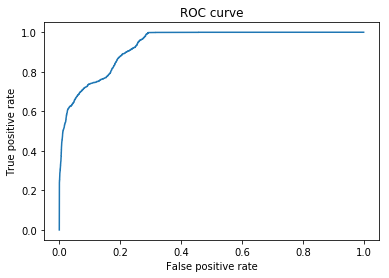

/Users/Theo/anaconda3/lib/python3.7/site-packages/sklearn/ensemble/iforest.py:417: DeprecationWarning:

threshold_ attribute is deprecated in 0.20 and will be removed in 0.22.

/Users/Theo/anaconda3/lib/python3.7/site-packages/sklearn/ensemble/iforest.py:417: DeprecationWarning:

threshold_ attribute is deprecated in 0.20 and will be removed in 0.22.

/Users/Theo/anaconda3/lib/python3.7/site-packages/sklearn/ensemble/iforest.py:213: FutureWarning:

default contamination parameter 0.1 will change in version 0.22 to "auto". This will change the predict method behavior.

/Users/Theo/anaconda3/lib/python3.7/site-packages/sklearn/ensemble/iforest.py:223: FutureWarning:

behaviour="old" is deprecated and will be removed in version 0.22. Please use behaviour="new", which makes the decision_function change to match other anomaly detection algorithm API.



f1_score= 0.4258271077908218


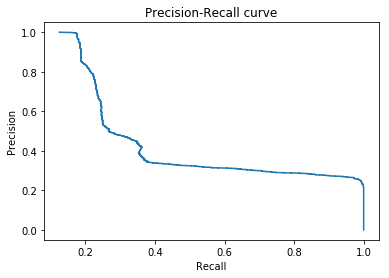

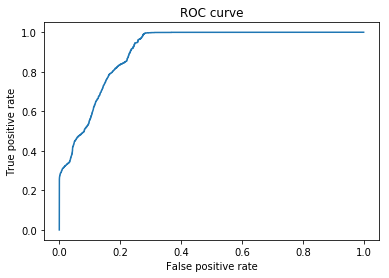

/Users/Theo/anaconda3/lib/python3.7/site-packages/sklearn/ensemble/iforest.py:417: DeprecationWarning:

threshold_ attribute is deprecated in 0.20 and will be removed in 0.22.

/Users/Theo/anaconda3/lib/python3.7/site-packages/sklearn/ensemble/iforest.py:417: DeprecationWarning:

threshold_ attribute is deprecated in 0.20 and will be removed in 0.22.

/Users/Theo/anaconda3/lib/python3.7/site-packages/sklearn/ensemble/iforest.py:213: FutureWarning:

default contamination parameter 0.1 will change in version 0.22 to "auto". This will change the predict method behavior.

/Users/Theo/anaconda3/lib/python3.7/site-packages/sklearn/ensemble/iforest.py:223: FutureWarning:

behaviour="old" is deprecated and will be removed in version 0.22. Please use behaviour="new", which makes the decision_function change to match other anomaly detection algorithm API.



f1_score= 0.4696075676688209


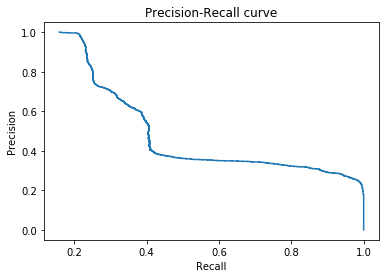

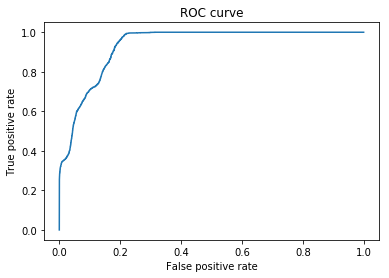

/Users/Theo/anaconda3/lib/python3.7/site-packages/sklearn/ensemble/iforest.py:417: DeprecationWarning:

threshold_ attribute is deprecated in 0.20 and will be removed in 0.22.

/Users/Theo/anaconda3/lib/python3.7/site-packages/sklearn/ensemble/iforest.py:417: DeprecationWarning:

threshold_ attribute is deprecated in 0.20 and will be removed in 0.22.

/Users/Theo/anaconda3/lib/python3.7/site-packages/sklearn/ensemble/iforest.py:213: FutureWarning:

default contamination parameter 0.1 will change in version 0.22 to "auto". This will change the predict method behavior.

/Users/Theo/anaconda3/lib/python3.7/site-packages/sklearn/ensemble/iforest.py:223: FutureWarning:

behaviour="old" is deprecated and will be removed in version 0.22. Please use behaviour="new", which makes the decision_function change to match other anomaly detection algorithm API.



f1_score= 0.4858289440682217


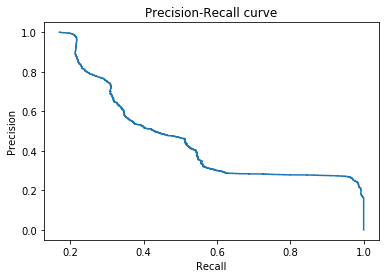

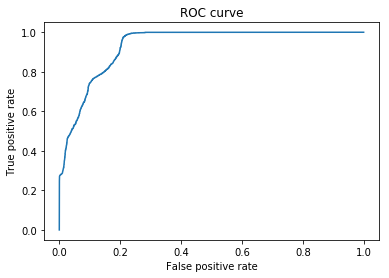

/Users/Theo/anaconda3/lib/python3.7/site-packages/sklearn/ensemble/iforest.py:417: DeprecationWarning:

threshold_ attribute is deprecated in 0.20 and will be removed in 0.22.

/Users/Theo/anaconda3/lib/python3.7/site-packages/sklearn/ensemble/iforest.py:417: DeprecationWarning:

threshold_ attribute is deprecated in 0.20 and will be removed in 0.22.

/Users/Theo/anaconda3/lib/python3.7/site-packages/sklearn/ensemble/iforest.py:213: FutureWarning:

default contamination parameter 0.1 will change in version 0.22 to "auto". This will change the predict method behavior.

/Users/Theo/anaconda3/lib/python3.7/site-packages/sklearn/ensemble/iforest.py:223: FutureWarning:

behaviour="old" is deprecated and will be removed in version 0.22. Please use behaviour="new", which makes the decision_function change to match other anomaly detection algorithm API.



f1_score= 0.5032528856243441


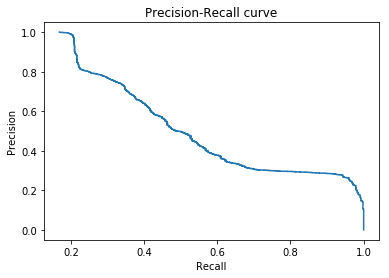

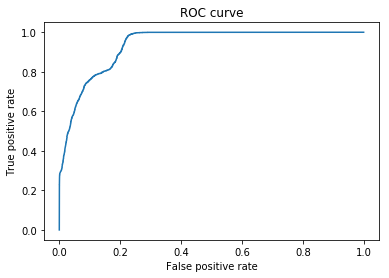

/Users/Theo/anaconda3/lib/python3.7/site-packages/sklearn/ensemble/iforest.py:417: DeprecationWarning:

threshold_ attribute is deprecated in 0.20 and will be removed in 0.22.

/Users/Theo/anaconda3/lib/python3.7/site-packages/sklearn/ensemble/iforest.py:417: DeprecationWarning:

threshold_ attribute is deprecated in 0.20 and will be removed in 0.22.

/Users/Theo/anaconda3/lib/python3.7/site-packages/sklearn/ensemble/iforest.py:213: FutureWarning:

default contamination parameter 0.1 will change in version 0.22 to "auto". This will change the predict method behavior.

/Users/Theo/anaconda3/lib/python3.7/site-packages/sklearn/ensemble/iforest.py:223: FutureWarning:

behaviour="old" is deprecated and will be removed in version 0.22. Please use behaviour="new", which makes the decision_function change to match other anomaly detection algorithm API.



f1_score= 0.533481043820778


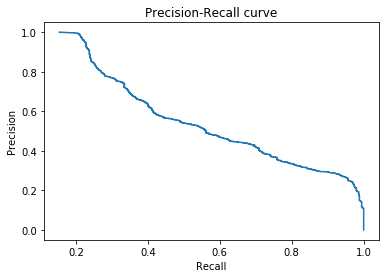

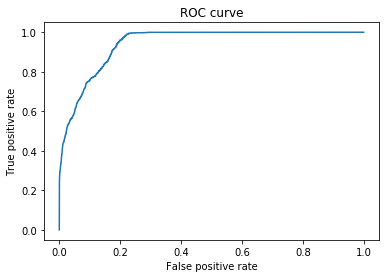

/Users/Theo/anaconda3/lib/python3.7/site-packages/sklearn/ensemble/iforest.py:417: DeprecationWarning:

threshold_ attribute is deprecated in 0.20 and will be removed in 0.22.

/Users/Theo/anaconda3/lib/python3.7/site-packages/sklearn/ensemble/iforest.py:417: DeprecationWarning:

threshold_ attribute is deprecated in 0.20 and will be removed in 0.22.

/Users/Theo/anaconda3/lib/python3.7/site-packages/sklearn/ensemble/iforest.py:213: FutureWarning:

default contamination parameter 0.1 will change in version 0.22 to "auto". This will change the predict method behavior.

/Users/Theo/anaconda3/lib/python3.7/site-packages/sklearn/ensemble/iforest.py:223: FutureWarning:

behaviour="old" is deprecated and will be removed in version 0.22. Please use behaviour="new", which makes the decision_function change to match other anomaly detection algorithm API.



f1_score= 0.5846192764988615


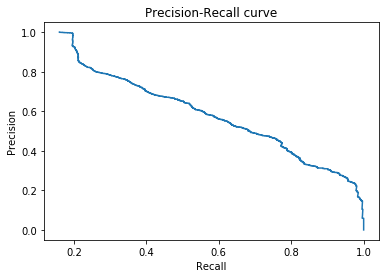

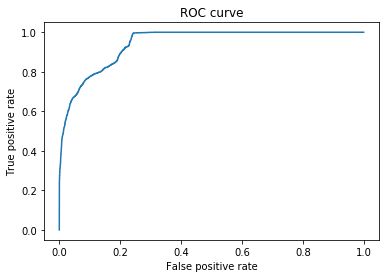

/Users/Theo/anaconda3/lib/python3.7/site-packages/sklearn/ensemble/iforest.py:417: DeprecationWarning:

threshold_ attribute is deprecated in 0.20 and will be removed in 0.22.

/Users/Theo/anaconda3/lib/python3.7/site-packages/sklearn/ensemble/iforest.py:417: DeprecationWarning:

threshold_ attribute is deprecated in 0.20 and will be removed in 0.22.

/Users/Theo/anaconda3/lib/python3.7/site-packages/sklearn/ensemble/iforest.py:213: FutureWarning:

default contamination parameter 0.1 will change in version 0.22 to "auto". This will change the predict method behavior.

/Users/Theo/anaconda3/lib/python3.7/site-packages/sklearn/ensemble/iforest.py:223: FutureWarning:

behaviour="old" is deprecated and will be removed in version 0.22. Please use behaviour="new", which makes the decision_function change to match other anomaly detection algorithm API.



f1_score= 0.5601711983887211


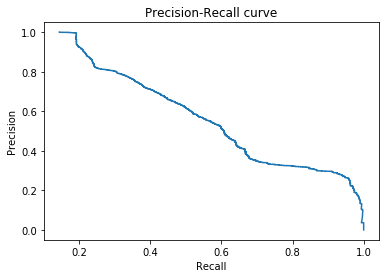

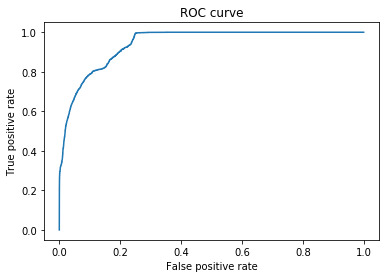

/Users/Theo/anaconda3/lib/python3.7/site-packages/sklearn/ensemble/iforest.py:417: DeprecationWarning:

threshold_ attribute is deprecated in 0.20 and will be removed in 0.22.

/Users/Theo/anaconda3/lib/python3.7/site-packages/sklearn/ensemble/iforest.py:417: DeprecationWarning:

threshold_ attribute is deprecated in 0.20 and will be removed in 0.22.

/Users/Theo/anaconda3/lib/python3.7/site-packages/sklearn/ensemble/iforest.py:213: FutureWarning:

default contamination parameter 0.1 will change in version 0.22 to "auto". This will change the predict method behavior.

/Users/Theo/anaconda3/lib/python3.7/site-packages/sklearn/ensemble/iforest.py:223: FutureWarning:

behaviour="old" is deprecated and will be removed in version 0.22. Please use behaviour="new", which makes the decision_function change to match other anomaly detection algorithm API.



f1_score= 0.5858470335954253


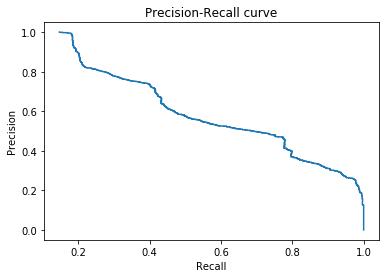

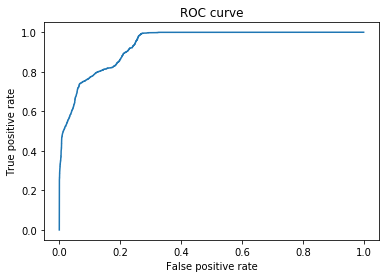

/Users/Theo/anaconda3/lib/python3.7/site-packages/sklearn/ensemble/iforest.py:417: DeprecationWarning:

threshold_ attribute is deprecated in 0.20 and will be removed in 0.22.

/Users/Theo/anaconda3/lib/python3.7/site-packages/sklearn/ensemble/iforest.py:417: DeprecationWarning:

threshold_ attribute is deprecated in 0.20 and will be removed in 0.22.

/Users/Theo/anaconda3/lib/python3.7/site-packages/sklearn/ensemble/iforest.py:213: FutureWarning:

default contamination parameter 0.1 will change in version 0.22 to "auto". This will change the predict method behavior.

/Users/Theo/anaconda3/lib/python3.7/site-packages/sklearn/ensemble/iforest.py:223: FutureWarning:

behaviour="old" is deprecated and will be removed in version 0.22. Please use behaviour="new", which makes the decision_function change to match other anomaly detection algorithm API.



f1_score= 0.5793084522502744


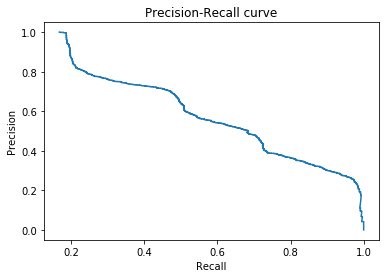

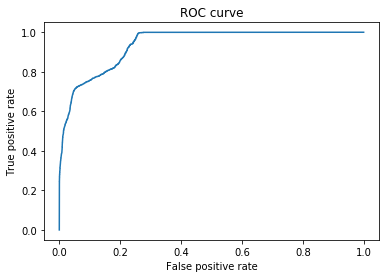

/Users/Theo/anaconda3/lib/python3.7/site-packages/sklearn/ensemble/iforest.py:417: DeprecationWarning:

threshold_ attribute is deprecated in 0.20 and will be removed in 0.22.

/Users/Theo/anaconda3/lib/python3.7/site-packages/sklearn/ensemble/iforest.py:417: DeprecationWarning:

threshold_ attribute is deprecated in 0.20 and will be removed in 0.22.

/Users/Theo/anaconda3/lib/python3.7/site-packages/sklearn/ensemble/iforest.py:213: FutureWarning:

default contamination parameter 0.1 will change in version 0.22 to "auto". This will change the predict method behavior.

/Users/Theo/anaconda3/lib/python3.7/site-packages/sklearn/ensemble/iforest.py:223: FutureWarning:

behaviour="old" is deprecated and will be removed in version 0.22. Please use behaviour="new", which makes the decision_function change to match other anomaly detection algorithm API.



f1_score= 0.542728297632469


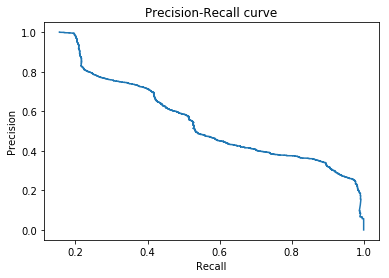

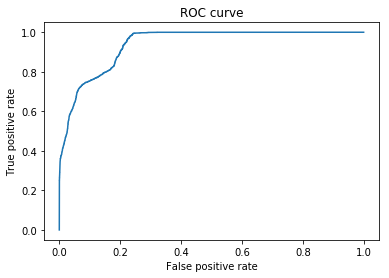

/Users/Theo/anaconda3/lib/python3.7/site-packages/sklearn/ensemble/iforest.py:417: DeprecationWarning:

threshold_ attribute is deprecated in 0.20 and will be removed in 0.22.

/Users/Theo/anaconda3/lib/python3.7/site-packages/sklearn/ensemble/iforest.py:417: DeprecationWarning:

threshold_ attribute is deprecated in 0.20 and will be removed in 0.22.

/Users/Theo/anaconda3/lib/python3.7/site-packages/sklearn/ensemble/iforest.py:213: FutureWarning:

default contamination parameter 0.1 will change in version 0.22 to "auto". This will change the predict method behavior.

/Users/Theo/anaconda3/lib/python3.7/site-packages/sklearn/ensemble/iforest.py:223: FutureWarning:

behaviour="old" is deprecated and will be removed in version 0.22. Please use behaviour="new", which makes the decision_function change to match other anomaly detection algorithm API.



f1_score= 0.3932394366197184


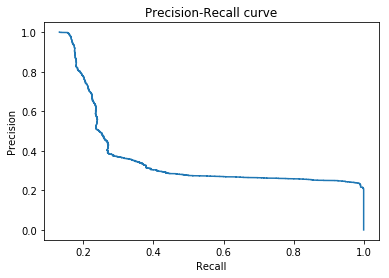

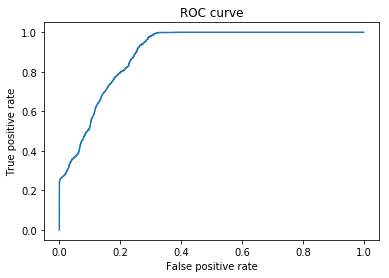

/Users/Theo/anaconda3/lib/python3.7/site-packages/sklearn/ensemble/iforest.py:417: DeprecationWarning:

threshold_ attribute is deprecated in 0.20 and will be removed in 0.22.

/Users/Theo/anaconda3/lib/python3.7/site-packages/sklearn/ensemble/iforest.py:417: DeprecationWarning:

threshold_ attribute is deprecated in 0.20 and will be removed in 0.22.

/Users/Theo/anaconda3/lib/python3.7/site-packages/sklearn/ensemble/iforest.py:213: FutureWarning:

default contamination parameter 0.1 will change in version 0.22 to "auto". This will change the predict method behavior.

/Users/Theo/anaconda3/lib/python3.7/site-packages/sklearn/ensemble/iforest.py:223: FutureWarning:

behaviour="old" is deprecated and will be removed in version 0.22. Please use behaviour="new", which makes the decision_function change to match other anomaly detection algorithm API.



f1_score= 0.4532516307570666


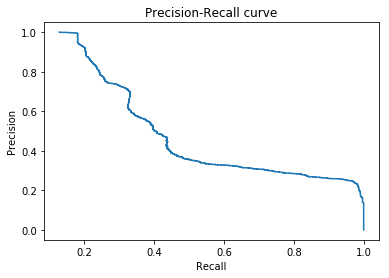

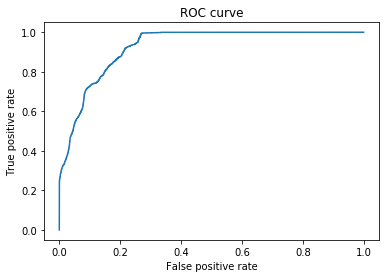

/Users/Theo/anaconda3/lib/python3.7/site-packages/sklearn/ensemble/iforest.py:417: DeprecationWarning:

threshold_ attribute is deprecated in 0.20 and will be removed in 0.22.

/Users/Theo/anaconda3/lib/python3.7/site-packages/sklearn/ensemble/iforest.py:417: DeprecationWarning:

threshold_ attribute is deprecated in 0.20 and will be removed in 0.22.

/Users/Theo/anaconda3/lib/python3.7/site-packages/sklearn/ensemble/iforest.py:213: FutureWarning:

default contamination parameter 0.1 will change in version 0.22 to "auto". This will change the predict method behavior.

/Users/Theo/anaconda3/lib/python3.7/site-packages/sklearn/ensemble/iforest.py:223: FutureWarning:

behaviour="old" is deprecated and will be removed in version 0.22. Please use behaviour="new", which makes the decision_function change to match other anomaly detection algorithm API.



f1_score= 0.5249466123082897


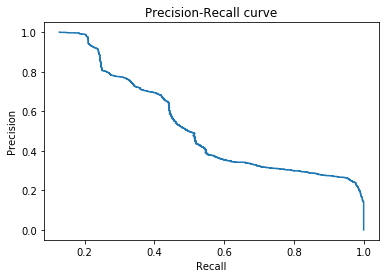

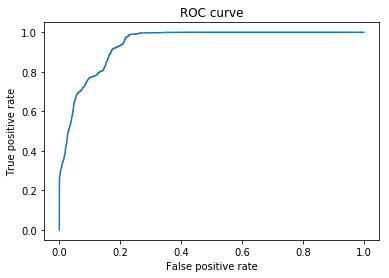

/Users/Theo/anaconda3/lib/python3.7/site-packages/sklearn/ensemble/iforest.py:417: DeprecationWarning:

threshold_ attribute is deprecated in 0.20 and will be removed in 0.22.

/Users/Theo/anaconda3/lib/python3.7/site-packages/sklearn/ensemble/iforest.py:417: DeprecationWarning:

threshold_ attribute is deprecated in 0.20 and will be removed in 0.22.

/Users/Theo/anaconda3/lib/python3.7/site-packages/sklearn/ensemble/iforest.py:213: FutureWarning:

default contamination parameter 0.1 will change in version 0.22 to "auto". This will change the predict method behavior.

/Users/Theo/anaconda3/lib/python3.7/site-packages/sklearn/ensemble/iforest.py:223: FutureWarning:

behaviour="old" is deprecated and will be removed in version 0.22. Please use behaviour="new", which makes the decision_function change to match other anomaly detection algorithm API.



f1_score= 0.599136690647482


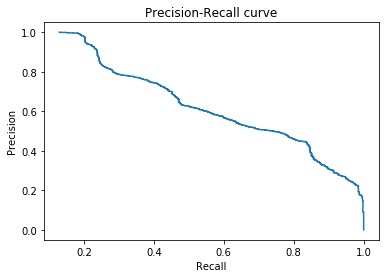

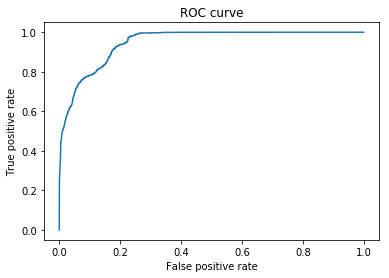

/Users/Theo/anaconda3/lib/python3.7/site-packages/sklearn/ensemble/iforest.py:417: DeprecationWarning:

threshold_ attribute is deprecated in 0.20 and will be removed in 0.22.

/Users/Theo/anaconda3/lib/python3.7/site-packages/sklearn/ensemble/iforest.py:417: DeprecationWarning:

threshold_ attribute is deprecated in 0.20 and will be removed in 0.22.

/Users/Theo/anaconda3/lib/python3.7/site-packages/sklearn/ensemble/iforest.py:213: FutureWarning:

default contamination parameter 0.1 will change in version 0.22 to "auto". This will change the predict method behavior.

/Users/Theo/anaconda3/lib/python3.7/site-packages/sklearn/ensemble/iforest.py:223: FutureWarning:

behaviour="old" is deprecated and will be removed in version 0.22. Please use behaviour="new", which makes the decision_function change to match other anomaly detection algorithm API.



f1_score= 0.6297569359194697


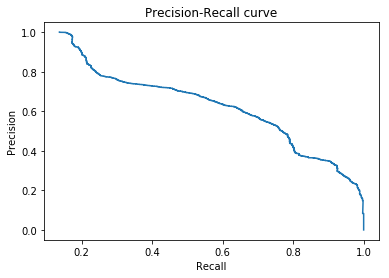

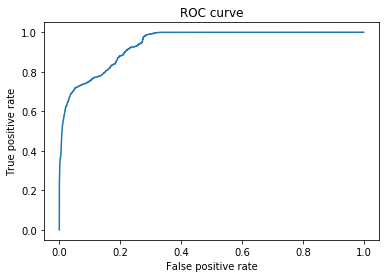

/Users/Theo/anaconda3/lib/python3.7/site-packages/sklearn/ensemble/iforest.py:417: DeprecationWarning:

threshold_ attribute is deprecated in 0.20 and will be removed in 0.22.

/Users/Theo/anaconda3/lib/python3.7/site-packages/sklearn/ensemble/iforest.py:417: DeprecationWarning:

threshold_ attribute is deprecated in 0.20 and will be removed in 0.22.

/Users/Theo/anaconda3/lib/python3.7/site-packages/sklearn/ensemble/iforest.py:213: FutureWarning:

default contamination parameter 0.1 will change in version 0.22 to "auto". This will change the predict method behavior.

/Users/Theo/anaconda3/lib/python3.7/site-packages/sklearn/ensemble/iforest.py:223: FutureWarning:

behaviour="old" is deprecated and will be removed in version 0.22. Please use behaviour="new", which makes the decision_function change to match other anomaly detection algorithm API.



f1_score= 0.6301670527984391


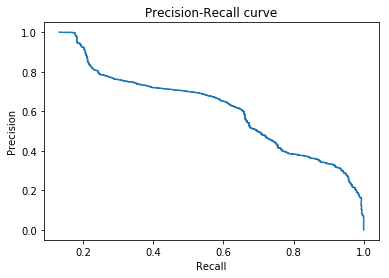

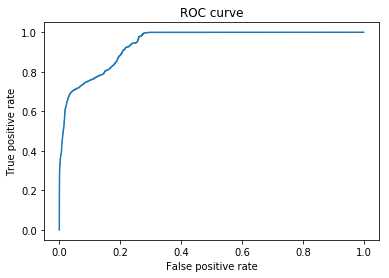

/Users/Theo/anaconda3/lib/python3.7/site-packages/sklearn/ensemble/iforest.py:417: DeprecationWarning:

threshold_ attribute is deprecated in 0.20 and will be removed in 0.22.

/Users/Theo/anaconda3/lib/python3.7/site-packages/sklearn/ensemble/iforest.py:417: DeprecationWarning:

threshold_ attribute is deprecated in 0.20 and will be removed in 0.22.

/Users/Theo/anaconda3/lib/python3.7/site-packages/sklearn/ensemble/iforest.py:213: FutureWarning:

default contamination parameter 0.1 will change in version 0.22 to "auto". This will change the predict method behavior.

/Users/Theo/anaconda3/lib/python3.7/site-packages/sklearn/ensemble/iforest.py:223: FutureWarning:

behaviour="old" is deprecated and will be removed in version 0.22. Please use behaviour="new", which makes the decision_function change to match other anomaly detection algorithm API.



f1_score= 0.5475292919001529


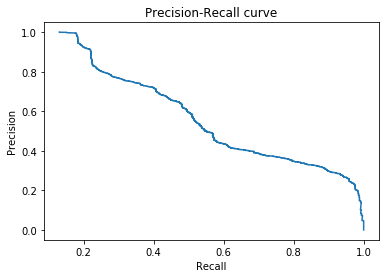

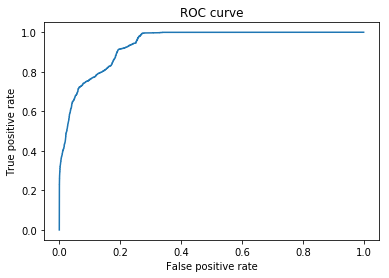

/Users/Theo/anaconda3/lib/python3.7/site-packages/sklearn/ensemble/iforest.py:417: DeprecationWarning:

threshold_ attribute is deprecated in 0.20 and will be removed in 0.22.

/Users/Theo/anaconda3/lib/python3.7/site-packages/sklearn/ensemble/iforest.py:417: DeprecationWarning:

threshold_ attribute is deprecated in 0.20 and will be removed in 0.22.

/Users/Theo/anaconda3/lib/python3.7/site-packages/sklearn/ensemble/iforest.py:213: FutureWarning:

default contamination parameter 0.1 will change in version 0.22 to "auto". This will change the predict method behavior.

/Users/Theo/anaconda3/lib/python3.7/site-packages/sklearn/ensemble/iforest.py:223: FutureWarning:

behaviour="old" is deprecated and will be removed in version 0.22. Please use behaviour="new", which makes the decision_function change to match other anomaly detection algorithm API.



f1_score= 0.5827258124304955


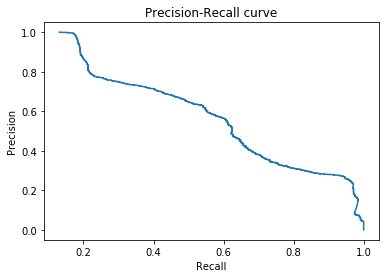

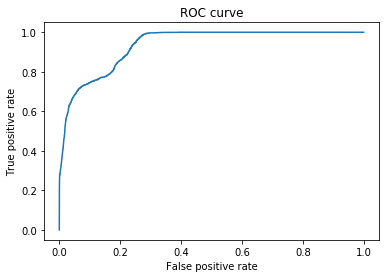

/Users/Theo/anaconda3/lib/python3.7/site-packages/sklearn/ensemble/iforest.py:417: DeprecationWarning:

threshold_ attribute is deprecated in 0.20 and will be removed in 0.22.

/Users/Theo/anaconda3/lib/python3.7/site-packages/sklearn/ensemble/iforest.py:417: DeprecationWarning:

threshold_ attribute is deprecated in 0.20 and will be removed in 0.22.

/Users/Theo/anaconda3/lib/python3.7/site-packages/sklearn/ensemble/iforest.py:213: FutureWarning:

default contamination parameter 0.1 will change in version 0.22 to "auto". This will change the predict method behavior.

/Users/Theo/anaconda3/lib/python3.7/site-packages/sklearn/ensemble/iforest.py:223: FutureWarning:

behaviour="old" is deprecated and will be removed in version 0.22. Please use behaviour="new", which makes the decision_function change to match other anomaly detection algorithm API.



f1_score= 0.5893969672034796


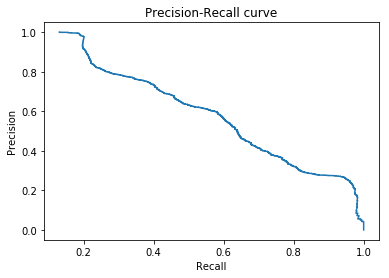

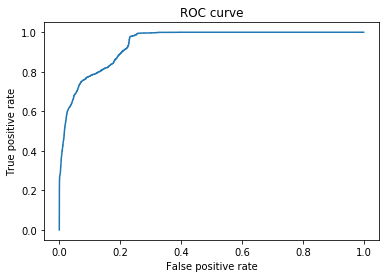

/Users/Theo/anaconda3/lib/python3.7/site-packages/sklearn/ensemble/iforest.py:417: DeprecationWarning:

threshold_ attribute is deprecated in 0.20 and will be removed in 0.22.

/Users/Theo/anaconda3/lib/python3.7/site-packages/sklearn/ensemble/iforest.py:417: DeprecationWarning:

threshold_ attribute is deprecated in 0.20 and will be removed in 0.22.

/Users/Theo/anaconda3/lib/python3.7/site-packages/sklearn/ensemble/iforest.py:213: FutureWarning:

default contamination parameter 0.1 will change in version 0.22 to "auto". This will change the predict method behavior.

/Users/Theo/anaconda3/lib/python3.7/site-packages/sklearn/ensemble/iforest.py:223: FutureWarning:

behaviour="old" is deprecated and will be removed in version 0.22. Please use behaviour="new", which makes the decision_function change to match other anomaly detection algorithm API.



f1_score= 0.5255958106230629


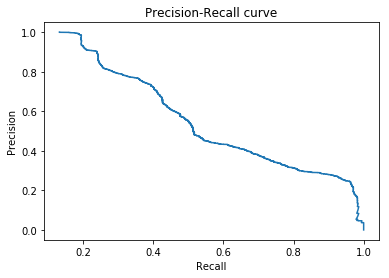

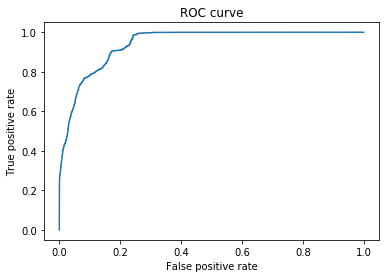

/Users/Theo/anaconda3/lib/python3.7/site-packages/sklearn/ensemble/iforest.py:417: DeprecationWarning:

threshold_ attribute is deprecated in 0.20 and will be removed in 0.22.

/Users/Theo/anaconda3/lib/python3.7/site-packages/sklearn/ensemble/iforest.py:417: DeprecationWarning:

threshold_ attribute is deprecated in 0.20 and will be removed in 0.22.

/Users/Theo/anaconda3/lib/python3.7/site-packages/sklearn/ensemble/iforest.py:213: FutureWarning:

default contamination parameter 0.1 will change in version 0.22 to "auto". This will change the predict method behavior.

/Users/Theo/anaconda3/lib/python3.7/site-packages/sklearn/ensemble/iforest.py:223: FutureWarning:

behaviour="old" is deprecated and will be removed in version 0.22. Please use behaviour="new", which makes the decision_function change to match other anomaly detection algorithm API.



f1_score= 0.3985122210414453


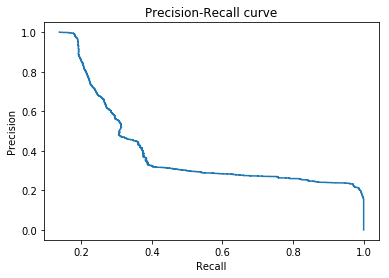

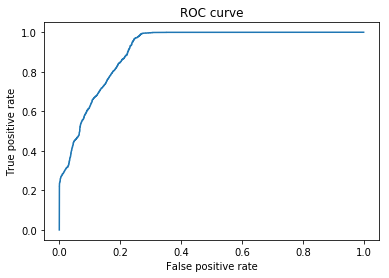

/Users/Theo/anaconda3/lib/python3.7/site-packages/sklearn/ensemble/iforest.py:417: DeprecationWarning:

threshold_ attribute is deprecated in 0.20 and will be removed in 0.22.

/Users/Theo/anaconda3/lib/python3.7/site-packages/sklearn/ensemble/iforest.py:417: DeprecationWarning:

threshold_ attribute is deprecated in 0.20 and will be removed in 0.22.

/Users/Theo/anaconda3/lib/python3.7/site-packages/sklearn/ensemble/iforest.py:213: FutureWarning:

default contamination parameter 0.1 will change in version 0.22 to "auto". This will change the predict method behavior.

/Users/Theo/anaconda3/lib/python3.7/site-packages/sklearn/ensemble/iforest.py:223: FutureWarning:

behaviour="old" is deprecated and will be removed in version 0.22. Please use behaviour="new", which makes the decision_function change to match other anomaly detection algorithm API.



f1_score= 0.5527228842962739


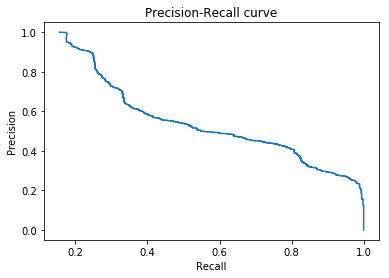

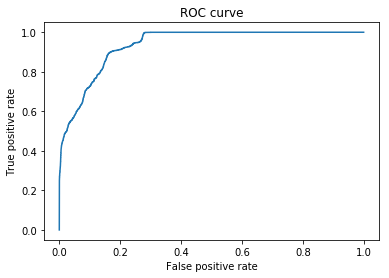

/Users/Theo/anaconda3/lib/python3.7/site-packages/sklearn/ensemble/iforest.py:417: DeprecationWarning:

threshold_ attribute is deprecated in 0.20 and will be removed in 0.22.

/Users/Theo/anaconda3/lib/python3.7/site-packages/sklearn/ensemble/iforest.py:417: DeprecationWarning:

threshold_ attribute is deprecated in 0.20 and will be removed in 0.22.

/Users/Theo/anaconda3/lib/python3.7/site-packages/sklearn/ensemble/iforest.py:213: FutureWarning:

default contamination parameter 0.1 will change in version 0.22 to "auto". This will change the predict method behavior.

/Users/Theo/anaconda3/lib/python3.7/site-packages/sklearn/ensemble/iforest.py:223: FutureWarning:

behaviour="old" is deprecated and will be removed in version 0.22. Please use behaviour="new", which makes the decision_function change to match other anomaly detection algorithm API.



f1_score= 0.5663919413919414


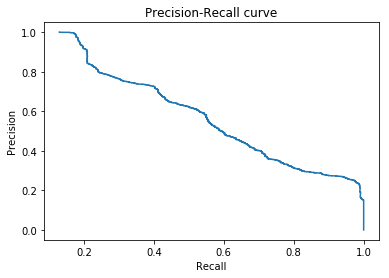

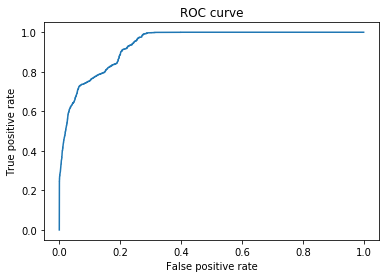

/Users/Theo/anaconda3/lib/python3.7/site-packages/sklearn/ensemble/iforest.py:417: DeprecationWarning:

threshold_ attribute is deprecated in 0.20 and will be removed in 0.22.

/Users/Theo/anaconda3/lib/python3.7/site-packages/sklearn/ensemble/iforest.py:417: DeprecationWarning:

threshold_ attribute is deprecated in 0.20 and will be removed in 0.22.

/Users/Theo/anaconda3/lib/python3.7/site-packages/sklearn/ensemble/iforest.py:213: FutureWarning:

default contamination parameter 0.1 will change in version 0.22 to "auto". This will change the predict method behavior.

/Users/Theo/anaconda3/lib/python3.7/site-packages/sklearn/ensemble/iforest.py:223: FutureWarning:

behaviour="old" is deprecated and will be removed in version 0.22. Please use behaviour="new", which makes the decision_function change to match other anomaly detection algorithm API.



f1_score= 0.5767790262172284


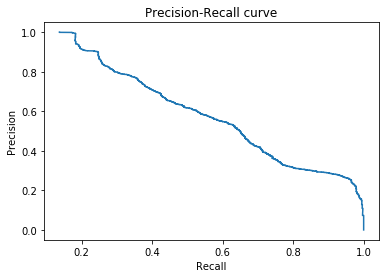

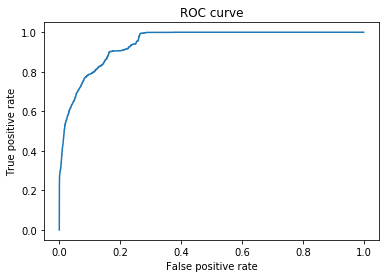

/Users/Theo/anaconda3/lib/python3.7/site-packages/sklearn/ensemble/iforest.py:417: DeprecationWarning:

threshold_ attribute is deprecated in 0.20 and will be removed in 0.22.

/Users/Theo/anaconda3/lib/python3.7/site-packages/sklearn/ensemble/iforest.py:417: DeprecationWarning:

threshold_ attribute is deprecated in 0.20 and will be removed in 0.22.

/Users/Theo/anaconda3/lib/python3.7/site-packages/sklearn/ensemble/iforest.py:213: FutureWarning:

default contamination parameter 0.1 will change in version 0.22 to "auto". This will change the predict method behavior.

/Users/Theo/anaconda3/lib/python3.7/site-packages/sklearn/ensemble/iforest.py:223: FutureWarning:

behaviour="old" is deprecated and will be removed in version 0.22. Please use behaviour="new", which makes the decision_function change to match other anomaly detection algorithm API.



f1_score= 0.6315214422288992


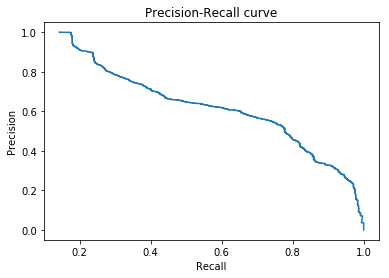

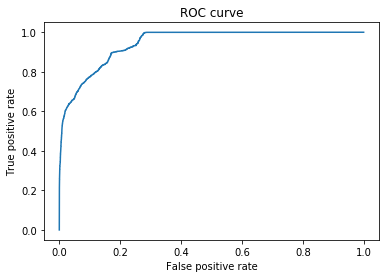

/Users/Theo/anaconda3/lib/python3.7/site-packages/sklearn/ensemble/iforest.py:417: DeprecationWarning:

threshold_ attribute is deprecated in 0.20 and will be removed in 0.22.

/Users/Theo/anaconda3/lib/python3.7/site-packages/sklearn/ensemble/iforest.py:417: DeprecationWarning:

threshold_ attribute is deprecated in 0.20 and will be removed in 0.22.

/Users/Theo/anaconda3/lib/python3.7/site-packages/sklearn/ensemble/iforest.py:213: FutureWarning:

default contamination parameter 0.1 will change in version 0.22 to "auto". This will change the predict method behavior.

/Users/Theo/anaconda3/lib/python3.7/site-packages/sklearn/ensemble/iforest.py:223: FutureWarning:

behaviour="old" is deprecated and will be removed in version 0.22. Please use behaviour="new", which makes the decision_function change to match other anomaly detection algorithm API.



f1_score= 0.58653598142894


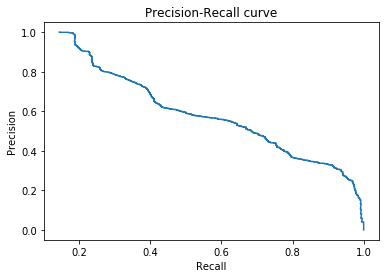

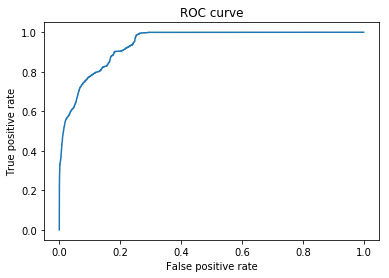

/Users/Theo/anaconda3/lib/python3.7/site-packages/sklearn/ensemble/iforest.py:417: DeprecationWarning:

threshold_ attribute is deprecated in 0.20 and will be removed in 0.22.

/Users/Theo/anaconda3/lib/python3.7/site-packages/sklearn/ensemble/iforest.py:417: DeprecationWarning:

threshold_ attribute is deprecated in 0.20 and will be removed in 0.22.

/Users/Theo/anaconda3/lib/python3.7/site-packages/sklearn/ensemble/iforest.py:213: FutureWarning:

default contamination parameter 0.1 will change in version 0.22 to "auto". This will change the predict method behavior.

/Users/Theo/anaconda3/lib/python3.7/site-packages/sklearn/ensemble/iforest.py:223: FutureWarning:

behaviour="old" is deprecated and will be removed in version 0.22. Please use behaviour="new", which makes the decision_function change to match other anomaly detection algorithm API.



f1_score= 0.6086608927381746


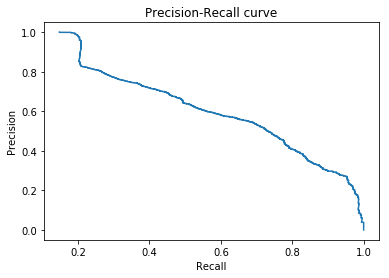

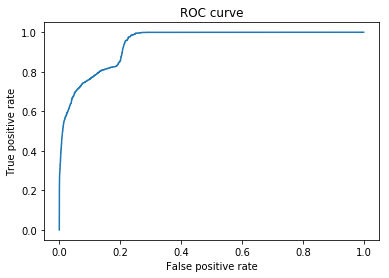

/Users/Theo/anaconda3/lib/python3.7/site-packages/sklearn/ensemble/iforest.py:417: DeprecationWarning:

threshold_ attribute is deprecated in 0.20 and will be removed in 0.22.

/Users/Theo/anaconda3/lib/python3.7/site-packages/sklearn/ensemble/iforest.py:417: DeprecationWarning:

threshold_ attribute is deprecated in 0.20 and will be removed in 0.22.

/Users/Theo/anaconda3/lib/python3.7/site-packages/sklearn/ensemble/iforest.py:213: FutureWarning:

default contamination parameter 0.1 will change in version 0.22 to "auto". This will change the predict method behavior.

/Users/Theo/anaconda3/lib/python3.7/site-packages/sklearn/ensemble/iforest.py:223: FutureWarning:

behaviour="old" is deprecated and will be removed in version 0.22. Please use behaviour="new", which makes the decision_function change to match other anomaly detection algorithm API.



f1_score= 0.693446088794926


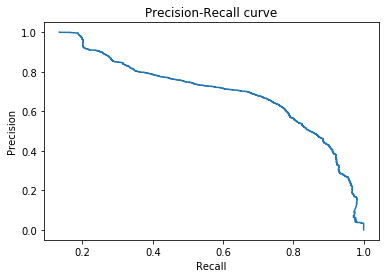

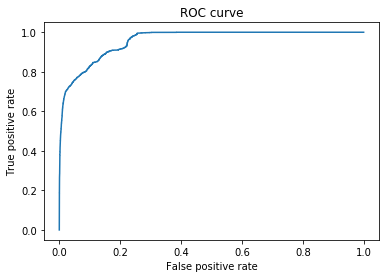

/Users/Theo/anaconda3/lib/python3.7/site-packages/sklearn/ensemble/iforest.py:417: DeprecationWarning:

threshold_ attribute is deprecated in 0.20 and will be removed in 0.22.

/Users/Theo/anaconda3/lib/python3.7/site-packages/sklearn/ensemble/iforest.py:417: DeprecationWarning:

threshold_ attribute is deprecated in 0.20 and will be removed in 0.22.

/Users/Theo/anaconda3/lib/python3.7/site-packages/sklearn/ensemble/iforest.py:213: FutureWarning:

default contamination parameter 0.1 will change in version 0.22 to "auto". This will change the predict method behavior.

/Users/Theo/anaconda3/lib/python3.7/site-packages/sklearn/ensemble/iforest.py:223: FutureWarning:

behaviour="old" is deprecated and will be removed in version 0.22. Please use behaviour="new", which makes the decision_function change to match other anomaly detection algorithm API.



f1_score= 0.6405959031657356


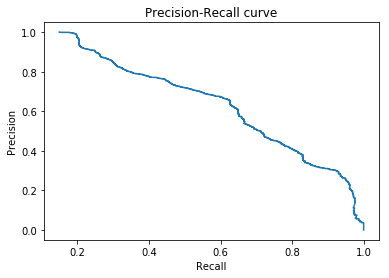

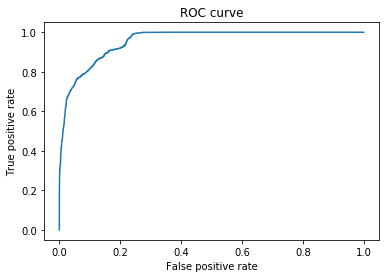

/Users/Theo/anaconda3/lib/python3.7/site-packages/sklearn/ensemble/iforest.py:417: DeprecationWarning:

threshold_ attribute is deprecated in 0.20 and will be removed in 0.22.

/Users/Theo/anaconda3/lib/python3.7/site-packages/sklearn/ensemble/iforest.py:417: DeprecationWarning:

threshold_ attribute is deprecated in 0.20 and will be removed in 0.22.

/Users/Theo/anaconda3/lib/python3.7/site-packages/sklearn/ensemble/iforest.py:213: FutureWarning:

default contamination parameter 0.1 will change in version 0.22 to "auto". This will change the predict method behavior.

/Users/Theo/anaconda3/lib/python3.7/site-packages/sklearn/ensemble/iforest.py:223: FutureWarning:

behaviour="old" is deprecated and will be removed in version 0.22. Please use behaviour="new", which makes the decision_function change to match other anomaly detection algorithm API.



f1_score= 0.6341834792539017


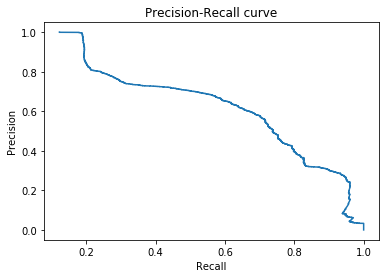

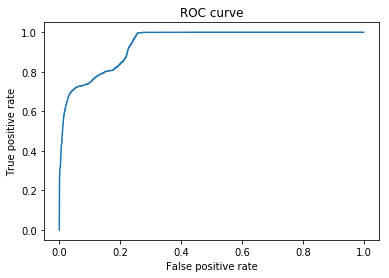

/Users/Theo/anaconda3/lib/python3.7/site-packages/sklearn/ensemble/iforest.py:417: DeprecationWarning:

threshold_ attribute is deprecated in 0.20 and will be removed in 0.22.

/Users/Theo/anaconda3/lib/python3.7/site-packages/sklearn/ensemble/iforest.py:417: DeprecationWarning:

threshold_ attribute is deprecated in 0.20 and will be removed in 0.22.

/Users/Theo/anaconda3/lib/python3.7/site-packages/sklearn/ensemble/iforest.py:213: FutureWarning:

default contamination parameter 0.1 will change in version 0.22 to "auto". This will change the predict method behavior.

/Users/Theo/anaconda3/lib/python3.7/site-packages/sklearn/ensemble/iforest.py:223: FutureWarning:

behaviour="old" is deprecated and will be removed in version 0.22. Please use behaviour="new", which makes the decision_function change to match other anomaly detection algorithm API.



f1_score= 0.40163781872324583


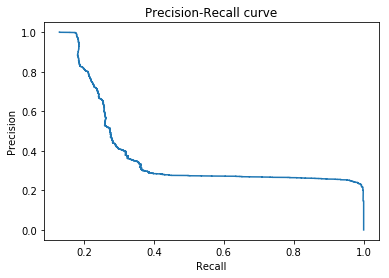

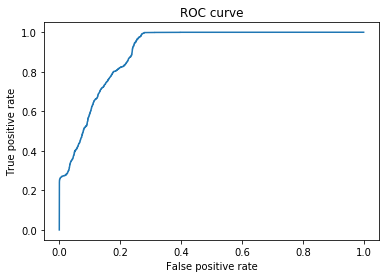

/Users/Theo/anaconda3/lib/python3.7/site-packages/sklearn/ensemble/iforest.py:417: DeprecationWarning:

threshold_ attribute is deprecated in 0.20 and will be removed in 0.22.

/Users/Theo/anaconda3/lib/python3.7/site-packages/sklearn/ensemble/iforest.py:417: DeprecationWarning:

threshold_ attribute is deprecated in 0.20 and will be removed in 0.22.

/Users/Theo/anaconda3/lib/python3.7/site-packages/sklearn/ensemble/iforest.py:213: FutureWarning:

default contamination parameter 0.1 will change in version 0.22 to "auto". This will change the predict method behavior.

/Users/Theo/anaconda3/lib/python3.7/site-packages/sklearn/ensemble/iforest.py:223: FutureWarning:

behaviour="old" is deprecated and will be removed in version 0.22. Please use behaviour="new", which makes the decision_function change to match other anomaly detection algorithm API.



f1_score= 0.45571130331046816


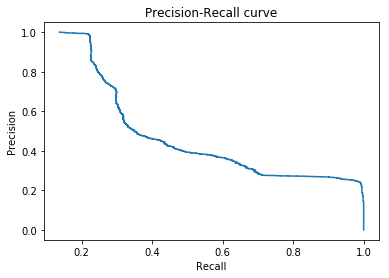

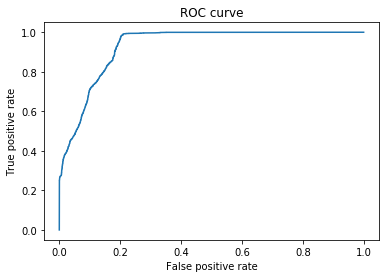

/Users/Theo/anaconda3/lib/python3.7/site-packages/sklearn/ensemble/iforest.py:417: DeprecationWarning:

threshold_ attribute is deprecated in 0.20 and will be removed in 0.22.

/Users/Theo/anaconda3/lib/python3.7/site-packages/sklearn/ensemble/iforest.py:417: DeprecationWarning:

threshold_ attribute is deprecated in 0.20 and will be removed in 0.22.

/Users/Theo/anaconda3/lib/python3.7/site-packages/sklearn/ensemble/iforest.py:213: FutureWarning:

default contamination parameter 0.1 will change in version 0.22 to "auto". This will change the predict method behavior.

/Users/Theo/anaconda3/lib/python3.7/site-packages/sklearn/ensemble/iforest.py:223: FutureWarning:

behaviour="old" is deprecated and will be removed in version 0.22. Please use behaviour="new", which makes the decision_function change to match other anomaly detection algorithm API.



f1_score= 0.5361229159856162


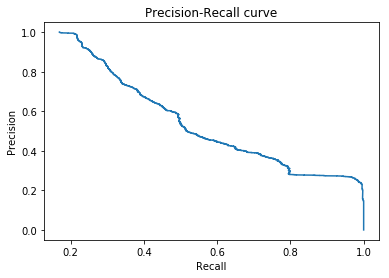

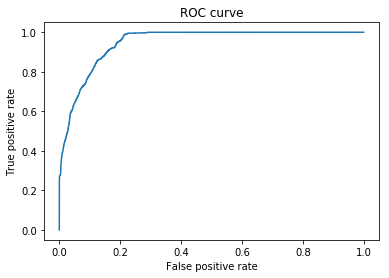

/Users/Theo/anaconda3/lib/python3.7/site-packages/sklearn/ensemble/iforest.py:417: DeprecationWarning:

threshold_ attribute is deprecated in 0.20 and will be removed in 0.22.

/Users/Theo/anaconda3/lib/python3.7/site-packages/sklearn/ensemble/iforest.py:417: DeprecationWarning:

threshold_ attribute is deprecated in 0.20 and will be removed in 0.22.

/Users/Theo/anaconda3/lib/python3.7/site-packages/sklearn/ensemble/iforest.py:213: FutureWarning:

default contamination parameter 0.1 will change in version 0.22 to "auto". This will change the predict method behavior.

/Users/Theo/anaconda3/lib/python3.7/site-packages/sklearn/ensemble/iforest.py:223: FutureWarning:

behaviour="old" is deprecated and will be removed in version 0.22. Please use behaviour="new", which makes the decision_function change to match other anomaly detection algorithm API.



f1_score= 0.503166887612314


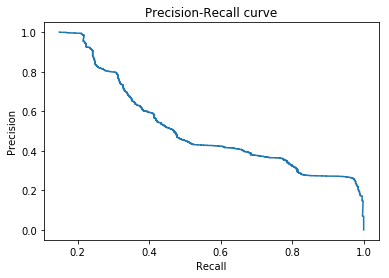

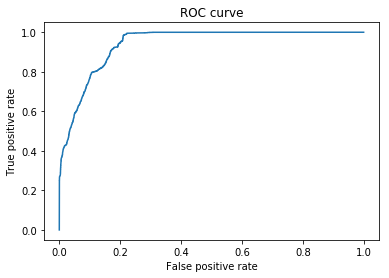

/Users/Theo/anaconda3/lib/python3.7/site-packages/sklearn/ensemble/iforest.py:417: DeprecationWarning:

threshold_ attribute is deprecated in 0.20 and will be removed in 0.22.

/Users/Theo/anaconda3/lib/python3.7/site-packages/sklearn/ensemble/iforest.py:417: DeprecationWarning:

threshold_ attribute is deprecated in 0.20 and will be removed in 0.22.

/Users/Theo/anaconda3/lib/python3.7/site-packages/sklearn/ensemble/iforest.py:213: FutureWarning:

default contamination parameter 0.1 will change in version 0.22 to "auto". This will change the predict method behavior.

/Users/Theo/anaconda3/lib/python3.7/site-packages/sklearn/ensemble/iforest.py:223: FutureWarning:

behaviour="old" is deprecated and will be removed in version 0.22. Please use behaviour="new", which makes the decision_function change to match other anomaly detection algorithm API.



f1_score= 0.5705314009661835


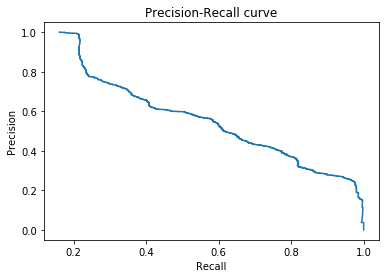

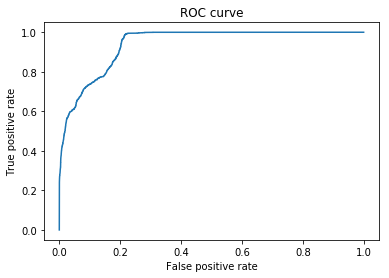

/Users/Theo/anaconda3/lib/python3.7/site-packages/sklearn/ensemble/iforest.py:417: DeprecationWarning:

threshold_ attribute is deprecated in 0.20 and will be removed in 0.22.

/Users/Theo/anaconda3/lib/python3.7/site-packages/sklearn/ensemble/iforest.py:417: DeprecationWarning:

threshold_ attribute is deprecated in 0.20 and will be removed in 0.22.

/Users/Theo/anaconda3/lib/python3.7/site-packages/sklearn/ensemble/iforest.py:213: FutureWarning:

default contamination parameter 0.1 will change in version 0.22 to "auto". This will change the predict method behavior.

/Users/Theo/anaconda3/lib/python3.7/site-packages/sklearn/ensemble/iforest.py:223: FutureWarning:

behaviour="old" is deprecated and will be removed in version 0.22. Please use behaviour="new", which makes the decision_function change to match other anomaly detection algorithm API.



f1_score= 0.5958663720265176


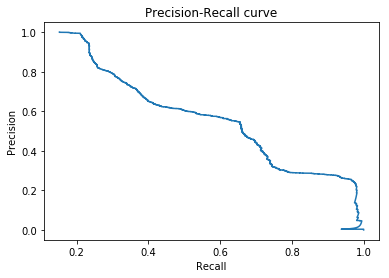

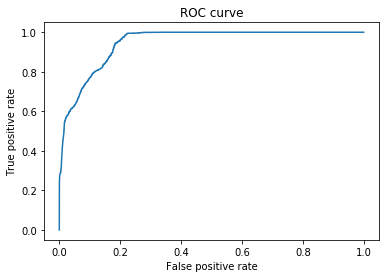

/Users/Theo/anaconda3/lib/python3.7/site-packages/sklearn/ensemble/iforest.py:417: DeprecationWarning:

threshold_ attribute is deprecated in 0.20 and will be removed in 0.22.

/Users/Theo/anaconda3/lib/python3.7/site-packages/sklearn/ensemble/iforest.py:417: DeprecationWarning:

threshold_ attribute is deprecated in 0.20 and will be removed in 0.22.

/Users/Theo/anaconda3/lib/python3.7/site-packages/sklearn/ensemble/iforest.py:213: FutureWarning:

default contamination parameter 0.1 will change in version 0.22 to "auto". This will change the predict method behavior.

/Users/Theo/anaconda3/lib/python3.7/site-packages/sklearn/ensemble/iforest.py:223: FutureWarning:

behaviour="old" is deprecated and will be removed in version 0.22. Please use behaviour="new", which makes the decision_function change to match other anomaly detection algorithm API.



f1_score= 0.5903538597154011


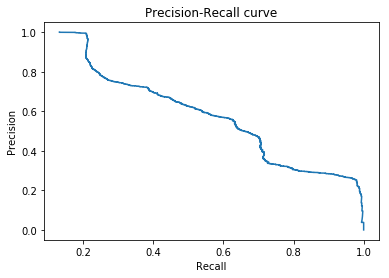

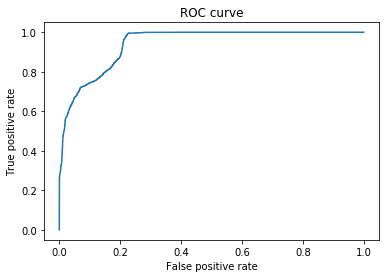

/Users/Theo/anaconda3/lib/python3.7/site-packages/sklearn/ensemble/iforest.py:417: DeprecationWarning:

threshold_ attribute is deprecated in 0.20 and will be removed in 0.22.

/Users/Theo/anaconda3/lib/python3.7/site-packages/sklearn/ensemble/iforest.py:417: DeprecationWarning:

threshold_ attribute is deprecated in 0.20 and will be removed in 0.22.

/Users/Theo/anaconda3/lib/python3.7/site-packages/sklearn/ensemble/iforest.py:213: FutureWarning:

default contamination parameter 0.1 will change in version 0.22 to "auto". This will change the predict method behavior.

/Users/Theo/anaconda3/lib/python3.7/site-packages/sklearn/ensemble/iforest.py:223: FutureWarning:

behaviour="old" is deprecated and will be removed in version 0.22. Please use behaviour="new", which makes the decision_function change to match other anomaly detection algorithm API.



f1_score= 0.564901349948079


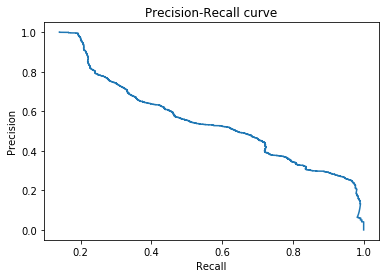

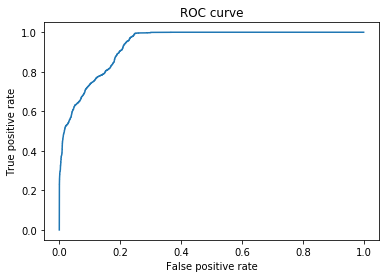

/Users/Theo/anaconda3/lib/python3.7/site-packages/sklearn/ensemble/iforest.py:417: DeprecationWarning:

threshold_ attribute is deprecated in 0.20 and will be removed in 0.22.

/Users/Theo/anaconda3/lib/python3.7/site-packages/sklearn/ensemble/iforest.py:417: DeprecationWarning:

threshold_ attribute is deprecated in 0.20 and will be removed in 0.22.

/Users/Theo/anaconda3/lib/python3.7/site-packages/sklearn/ensemble/iforest.py:213: FutureWarning:

default contamination parameter 0.1 will change in version 0.22 to "auto". This will change the predict method behavior.

/Users/Theo/anaconda3/lib/python3.7/site-packages/sklearn/ensemble/iforest.py:223: FutureWarning:

behaviour="old" is deprecated and will be removed in version 0.22. Please use behaviour="new", which makes the decision_function change to match other anomaly detection algorithm API.



f1_score= 0.5276485788113694


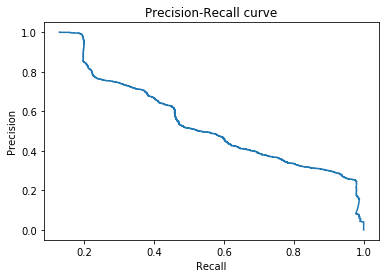

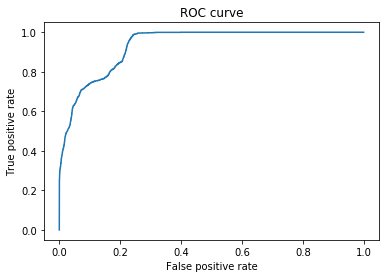

/Users/Theo/anaconda3/lib/python3.7/site-packages/sklearn/ensemble/iforest.py:417: DeprecationWarning:

threshold_ attribute is deprecated in 0.20 and will be removed in 0.22.

/Users/Theo/anaconda3/lib/python3.7/site-packages/sklearn/ensemble/iforest.py:417: DeprecationWarning:

threshold_ attribute is deprecated in 0.20 and will be removed in 0.22.

/Users/Theo/anaconda3/lib/python3.7/site-packages/sklearn/ensemble/iforest.py:213: FutureWarning:

default contamination parameter 0.1 will change in version 0.22 to "auto". This will change the predict method behavior.

/Users/Theo/anaconda3/lib/python3.7/site-packages/sklearn/ensemble/iforest.py:223: FutureWarning:

behaviour="old" is deprecated and will be removed in version 0.22. Please use behaviour="new", which makes the decision_function change to match other anomaly detection algorithm API.



f1_score= 0.5631646108039132


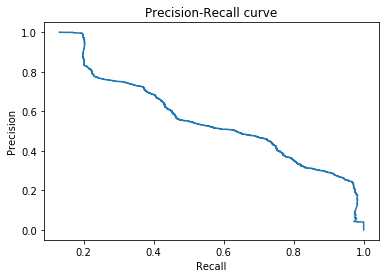

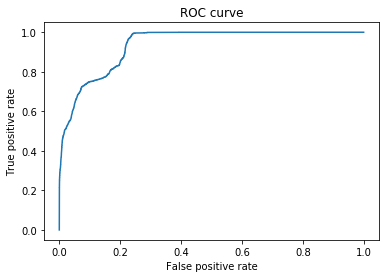

/Users/Theo/anaconda3/lib/python3.7/site-packages/sklearn/ensemble/iforest.py:417: DeprecationWarning:

threshold_ attribute is deprecated in 0.20 and will be removed in 0.22.

/Users/Theo/anaconda3/lib/python3.7/site-packages/sklearn/ensemble/iforest.py:417: DeprecationWarning:

threshold_ attribute is deprecated in 0.20 and will be removed in 0.22.

/Users/Theo/anaconda3/lib/python3.7/site-packages/sklearn/ensemble/iforest.py:213: FutureWarning:

default contamination parameter 0.1 will change in version 0.22 to "auto". This will change the predict method behavior.

/Users/Theo/anaconda3/lib/python3.7/site-packages/sklearn/ensemble/iforest.py:223: FutureWarning:

behaviour="old" is deprecated and will be removed in version 0.22. Please use behaviour="new", which makes the decision_function change to match other anomaly detection algorithm API.



f1_score= 0.4821198264743815


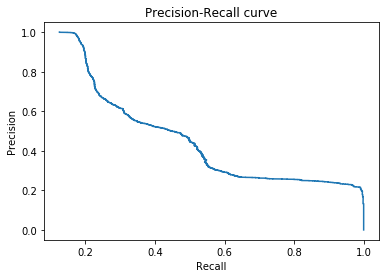

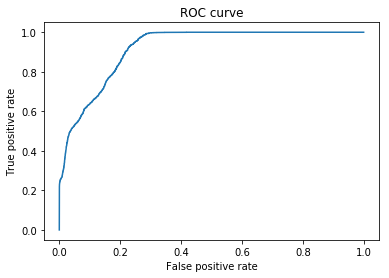

/Users/Theo/anaconda3/lib/python3.7/site-packages/sklearn/ensemble/iforest.py:417: DeprecationWarning:

threshold_ attribute is deprecated in 0.20 and will be removed in 0.22.

/Users/Theo/anaconda3/lib/python3.7/site-packages/sklearn/ensemble/iforest.py:417: DeprecationWarning:

threshold_ attribute is deprecated in 0.20 and will be removed in 0.22.

/Users/Theo/anaconda3/lib/python3.7/site-packages/sklearn/ensemble/iforest.py:213: FutureWarning:

default contamination parameter 0.1 will change in version 0.22 to "auto". This will change the predict method behavior.

/Users/Theo/anaconda3/lib/python3.7/site-packages/sklearn/ensemble/iforest.py:223: FutureWarning:

behaviour="old" is deprecated and will be removed in version 0.22. Please use behaviour="new", which makes the decision_function change to match other anomaly detection algorithm API.



f1_score= 0.4668400520156047


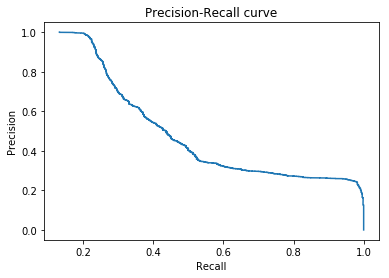

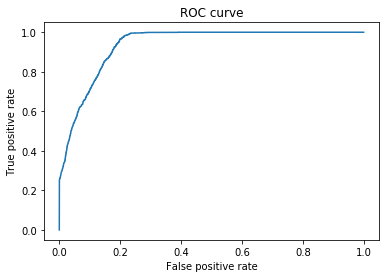

/Users/Theo/anaconda3/lib/python3.7/site-packages/sklearn/ensemble/iforest.py:417: DeprecationWarning:

threshold_ attribute is deprecated in 0.20 and will be removed in 0.22.

/Users/Theo/anaconda3/lib/python3.7/site-packages/sklearn/ensemble/iforest.py:417: DeprecationWarning:

threshold_ attribute is deprecated in 0.20 and will be removed in 0.22.

/Users/Theo/anaconda3/lib/python3.7/site-packages/sklearn/ensemble/iforest.py:213: FutureWarning:

default contamination parameter 0.1 will change in version 0.22 to "auto". This will change the predict method behavior.

/Users/Theo/anaconda3/lib/python3.7/site-packages/sklearn/ensemble/iforest.py:223: FutureWarning:

behaviour="old" is deprecated and will be removed in version 0.22. Please use behaviour="new", which makes the decision_function change to match other anomaly detection algorithm API.



f1_score= 0.5051120295845116


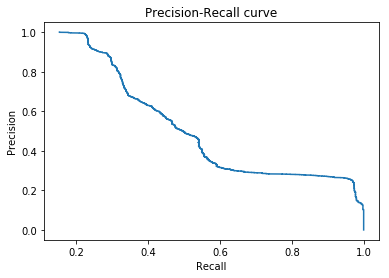

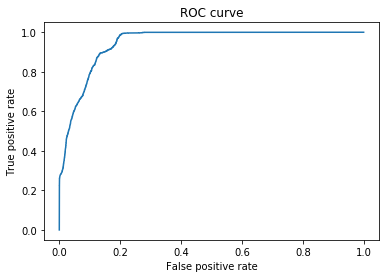

/Users/Theo/anaconda3/lib/python3.7/site-packages/sklearn/ensemble/iforest.py:417: DeprecationWarning:

threshold_ attribute is deprecated in 0.20 and will be removed in 0.22.

/Users/Theo/anaconda3/lib/python3.7/site-packages/sklearn/ensemble/iforest.py:417: DeprecationWarning:

threshold_ attribute is deprecated in 0.20 and will be removed in 0.22.

/Users/Theo/anaconda3/lib/python3.7/site-packages/sklearn/ensemble/iforest.py:213: FutureWarning:

default contamination parameter 0.1 will change in version 0.22 to "auto". This will change the predict method behavior.

/Users/Theo/anaconda3/lib/python3.7/site-packages/sklearn/ensemble/iforest.py:223: FutureWarning:

behaviour="old" is deprecated and will be removed in version 0.22. Please use behaviour="new", which makes the decision_function change to match other anomaly detection algorithm API.



f1_score= 0.5369974096182002


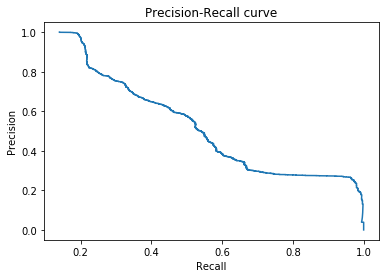

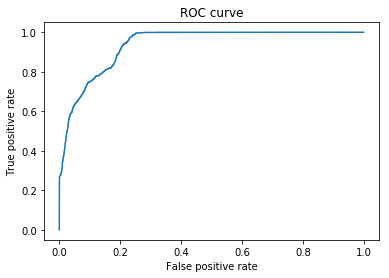

/Users/Theo/anaconda3/lib/python3.7/site-packages/sklearn/ensemble/iforest.py:417: DeprecationWarning:

threshold_ attribute is deprecated in 0.20 and will be removed in 0.22.

/Users/Theo/anaconda3/lib/python3.7/site-packages/sklearn/ensemble/iforest.py:417: DeprecationWarning:

threshold_ attribute is deprecated in 0.20 and will be removed in 0.22.

/Users/Theo/anaconda3/lib/python3.7/site-packages/sklearn/ensemble/iforest.py:213: FutureWarning:

default contamination parameter 0.1 will change in version 0.22 to "auto". This will change the predict method behavior.

/Users/Theo/anaconda3/lib/python3.7/site-packages/sklearn/ensemble/iforest.py:223: FutureWarning:

behaviour="old" is deprecated and will be removed in version 0.22. Please use behaviour="new", which makes the decision_function change to match other anomaly detection algorithm API.



f1_score= 0.5676238035788598


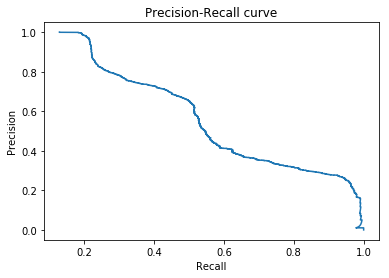

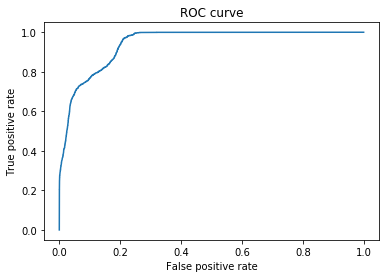

/Users/Theo/anaconda3/lib/python3.7/site-packages/sklearn/ensemble/iforest.py:417: DeprecationWarning:

threshold_ attribute is deprecated in 0.20 and will be removed in 0.22.

/Users/Theo/anaconda3/lib/python3.7/site-packages/sklearn/ensemble/iforest.py:417: DeprecationWarning:

threshold_ attribute is deprecated in 0.20 and will be removed in 0.22.

/Users/Theo/anaconda3/lib/python3.7/site-packages/sklearn/ensemble/iforest.py:213: FutureWarning:

default contamination parameter 0.1 will change in version 0.22 to "auto". This will change the predict method behavior.

/Users/Theo/anaconda3/lib/python3.7/site-packages/sklearn/ensemble/iforest.py:223: FutureWarning:

behaviour="old" is deprecated and will be removed in version 0.22. Please use behaviour="new", which makes the decision_function change to match other anomaly detection algorithm API.



f1_score= 0.6152732537097358


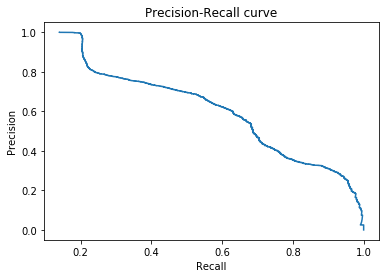

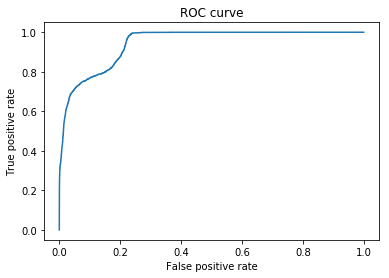

/Users/Theo/anaconda3/lib/python3.7/site-packages/sklearn/ensemble/iforest.py:417: DeprecationWarning:

threshold_ attribute is deprecated in 0.20 and will be removed in 0.22.

/Users/Theo/anaconda3/lib/python3.7/site-packages/sklearn/ensemble/iforest.py:417: DeprecationWarning:

threshold_ attribute is deprecated in 0.20 and will be removed in 0.22.

/Users/Theo/anaconda3/lib/python3.7/site-packages/sklearn/ensemble/iforest.py:213: FutureWarning:

default contamination parameter 0.1 will change in version 0.22 to "auto". This will change the predict method behavior.

/Users/Theo/anaconda3/lib/python3.7/site-packages/sklearn/ensemble/iforest.py:223: FutureWarning:

behaviour="old" is deprecated and will be removed in version 0.22. Please use behaviour="new", which makes the decision_function change to match other anomaly detection algorithm API.



f1_score= 0.5589980224126565


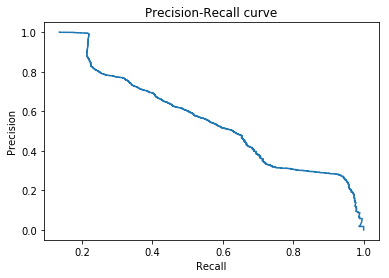

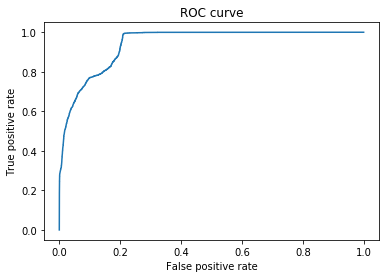

/Users/Theo/anaconda3/lib/python3.7/site-packages/sklearn/ensemble/iforest.py:417: DeprecationWarning:

threshold_ attribute is deprecated in 0.20 and will be removed in 0.22.

/Users/Theo/anaconda3/lib/python3.7/site-packages/sklearn/ensemble/iforest.py:417: DeprecationWarning:

threshold_ attribute is deprecated in 0.20 and will be removed in 0.22.

/Users/Theo/anaconda3/lib/python3.7/site-packages/sklearn/ensemble/iforest.py:213: FutureWarning:

default contamination parameter 0.1 will change in version 0.22 to "auto". This will change the predict method behavior.

/Users/Theo/anaconda3/lib/python3.7/site-packages/sklearn/ensemble/iforest.py:223: FutureWarning:

behaviour="old" is deprecated and will be removed in version 0.22. Please use behaviour="new", which makes the decision_function change to match other anomaly detection algorithm API.



f1_score= 0.5958644581574104


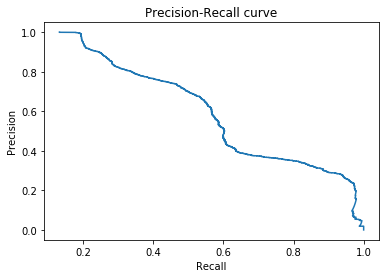

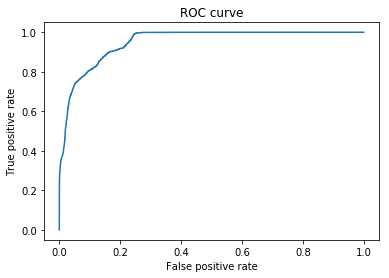

/Users/Theo/anaconda3/lib/python3.7/site-packages/sklearn/ensemble/iforest.py:417: DeprecationWarning:

threshold_ attribute is deprecated in 0.20 and will be removed in 0.22.

/Users/Theo/anaconda3/lib/python3.7/site-packages/sklearn/ensemble/iforest.py:417: DeprecationWarning:

threshold_ attribute is deprecated in 0.20 and will be removed in 0.22.

/Users/Theo/anaconda3/lib/python3.7/site-packages/sklearn/ensemble/iforest.py:213: FutureWarning:

default contamination parameter 0.1 will change in version 0.22 to "auto". This will change the predict method behavior.

/Users/Theo/anaconda3/lib/python3.7/site-packages/sklearn/ensemble/iforest.py:223: FutureWarning:

behaviour="old" is deprecated and will be removed in version 0.22. Please use behaviour="new", which makes the decision_function change to match other anomaly detection algorithm API.



f1_score= 0.6255649553830108


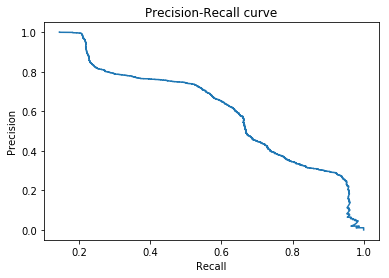

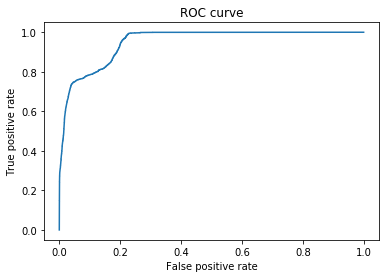

/Users/Theo/anaconda3/lib/python3.7/site-packages/sklearn/ensemble/iforest.py:417: DeprecationWarning:

threshold_ attribute is deprecated in 0.20 and will be removed in 0.22.

/Users/Theo/anaconda3/lib/python3.7/site-packages/sklearn/ensemble/iforest.py:417: DeprecationWarning:

threshold_ attribute is deprecated in 0.20 and will be removed in 0.22.

/Users/Theo/anaconda3/lib/python3.7/site-packages/sklearn/ensemble/iforest.py:213: FutureWarning:

default contamination parameter 0.1 will change in version 0.22 to "auto". This will change the predict method behavior.

/Users/Theo/anaconda3/lib/python3.7/site-packages/sklearn/ensemble/iforest.py:223: FutureWarning:

behaviour="old" is deprecated and will be removed in version 0.22. Please use behaviour="new", which makes the decision_function change to match other anomaly detection algorithm API.



f1_score= 0.5912803405038536


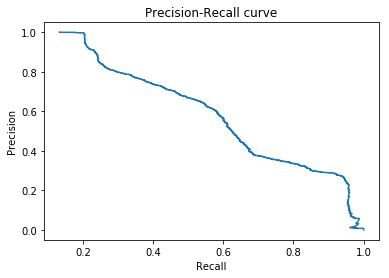

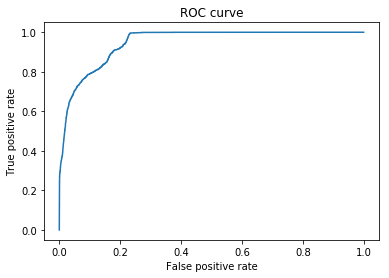

/Users/Theo/anaconda3/lib/python3.7/site-packages/sklearn/ensemble/iforest.py:417: DeprecationWarning:

threshold_ attribute is deprecated in 0.20 and will be removed in 0.22.

/Users/Theo/anaconda3/lib/python3.7/site-packages/sklearn/ensemble/iforest.py:417: DeprecationWarning:

threshold_ attribute is deprecated in 0.20 and will be removed in 0.22.

/Users/Theo/anaconda3/lib/python3.7/site-packages/sklearn/ensemble/iforest.py:213: FutureWarning:

default contamination parameter 0.1 will change in version 0.22 to "auto". This will change the predict method behavior.

/Users/Theo/anaconda3/lib/python3.7/site-packages/sklearn/ensemble/iforest.py:223: FutureWarning:

behaviour="old" is deprecated and will be removed in version 0.22. Please use behaviour="new", which makes the decision_function change to match other anomaly detection algorithm API.



f1_score= 0.41904971403431585


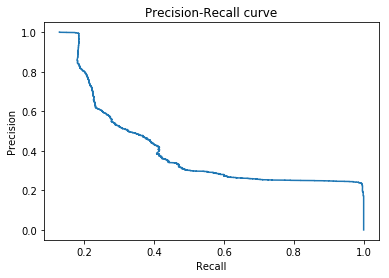

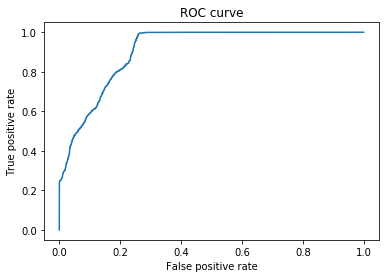

/Users/Theo/anaconda3/lib/python3.7/site-packages/sklearn/ensemble/iforest.py:417: DeprecationWarning:

threshold_ attribute is deprecated in 0.20 and will be removed in 0.22.

/Users/Theo/anaconda3/lib/python3.7/site-packages/sklearn/ensemble/iforest.py:417: DeprecationWarning:

threshold_ attribute is deprecated in 0.20 and will be removed in 0.22.

/Users/Theo/anaconda3/lib/python3.7/site-packages/sklearn/ensemble/iforest.py:213: FutureWarning:

default contamination parameter 0.1 will change in version 0.22 to "auto". This will change the predict method behavior.

/Users/Theo/anaconda3/lib/python3.7/site-packages/sklearn/ensemble/iforest.py:223: FutureWarning:

behaviour="old" is deprecated and will be removed in version 0.22. Please use behaviour="new", which makes the decision_function change to match other anomaly detection algorithm API.



f1_score= 0.44900706832716253


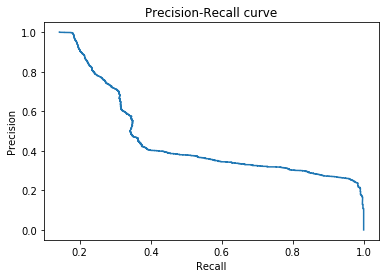

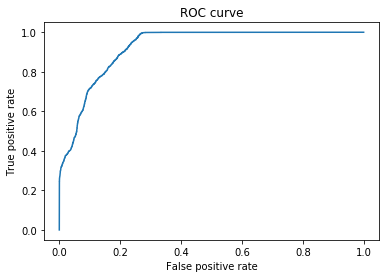

/Users/Theo/anaconda3/lib/python3.7/site-packages/sklearn/ensemble/iforest.py:417: DeprecationWarning:

threshold_ attribute is deprecated in 0.20 and will be removed in 0.22.

/Users/Theo/anaconda3/lib/python3.7/site-packages/sklearn/ensemble/iforest.py:417: DeprecationWarning:

threshold_ attribute is deprecated in 0.20 and will be removed in 0.22.

/Users/Theo/anaconda3/lib/python3.7/site-packages/sklearn/ensemble/iforest.py:213: FutureWarning:

default contamination parameter 0.1 will change in version 0.22 to "auto". This will change the predict method behavior.

/Users/Theo/anaconda3/lib/python3.7/site-packages/sklearn/ensemble/iforest.py:223: FutureWarning:

behaviour="old" is deprecated and will be removed in version 0.22. Please use behaviour="new", which makes the decision_function change to match other anomaly detection algorithm API.



f1_score= 0.5475684106054162


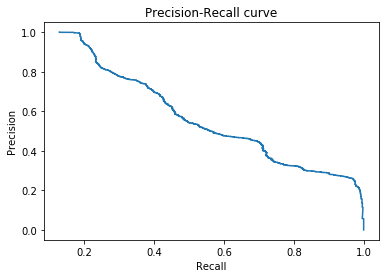

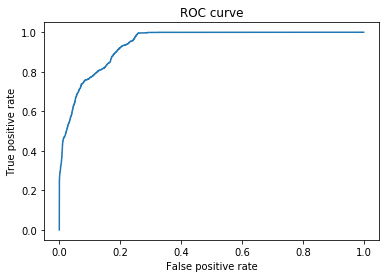

/Users/Theo/anaconda3/lib/python3.7/site-packages/sklearn/ensemble/iforest.py:417: DeprecationWarning:

threshold_ attribute is deprecated in 0.20 and will be removed in 0.22.

/Users/Theo/anaconda3/lib/python3.7/site-packages/sklearn/ensemble/iforest.py:417: DeprecationWarning:

threshold_ attribute is deprecated in 0.20 and will be removed in 0.22.

/Users/Theo/anaconda3/lib/python3.7/site-packages/sklearn/ensemble/iforest.py:213: FutureWarning:

default contamination parameter 0.1 will change in version 0.22 to "auto". This will change the predict method behavior.

/Users/Theo/anaconda3/lib/python3.7/site-packages/sklearn/ensemble/iforest.py:223: FutureWarning:

behaviour="old" is deprecated and will be removed in version 0.22. Please use behaviour="new", which makes the decision_function change to match other anomaly detection algorithm API.



f1_score= 0.5650857719475277


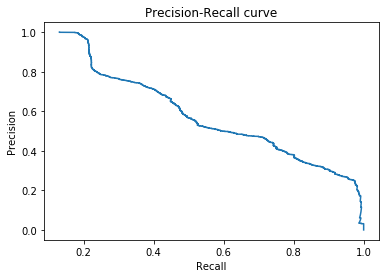

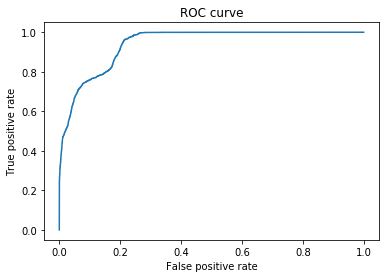

/Users/Theo/anaconda3/lib/python3.7/site-packages/sklearn/ensemble/iforest.py:417: DeprecationWarning:

threshold_ attribute is deprecated in 0.20 and will be removed in 0.22.

/Users/Theo/anaconda3/lib/python3.7/site-packages/sklearn/ensemble/iforest.py:417: DeprecationWarning:

threshold_ attribute is deprecated in 0.20 and will be removed in 0.22.

/Users/Theo/anaconda3/lib/python3.7/site-packages/sklearn/ensemble/iforest.py:213: FutureWarning:

default contamination parameter 0.1 will change in version 0.22 to "auto". This will change the predict method behavior.

/Users/Theo/anaconda3/lib/python3.7/site-packages/sklearn/ensemble/iforest.py:223: FutureWarning:

behaviour="old" is deprecated and will be removed in version 0.22. Please use behaviour="new", which makes the decision_function change to match other anomaly detection algorithm API.



f1_score= 0.5549222797927461


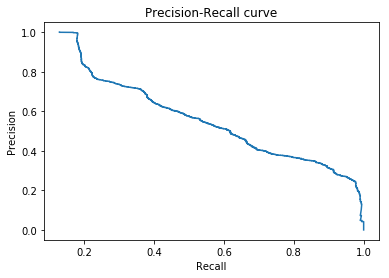

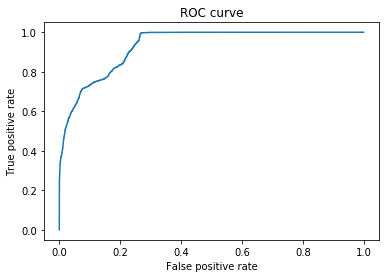

/Users/Theo/anaconda3/lib/python3.7/site-packages/sklearn/ensemble/iforest.py:417: DeprecationWarning:

threshold_ attribute is deprecated in 0.20 and will be removed in 0.22.

/Users/Theo/anaconda3/lib/python3.7/site-packages/sklearn/ensemble/iforest.py:417: DeprecationWarning:

threshold_ attribute is deprecated in 0.20 and will be removed in 0.22.

/Users/Theo/anaconda3/lib/python3.7/site-packages/sklearn/ensemble/iforest.py:213: FutureWarning:

default contamination parameter 0.1 will change in version 0.22 to "auto". This will change the predict method behavior.

/Users/Theo/anaconda3/lib/python3.7/site-packages/sklearn/ensemble/iforest.py:223: FutureWarning:

behaviour="old" is deprecated and will be removed in version 0.22. Please use behaviour="new", which makes the decision_function change to match other anomaly detection algorithm API.



f1_score= 0.5646275283670449


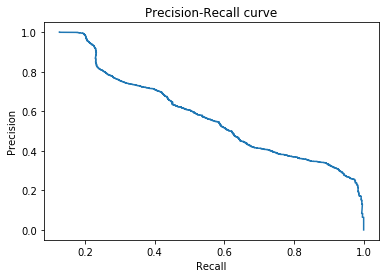

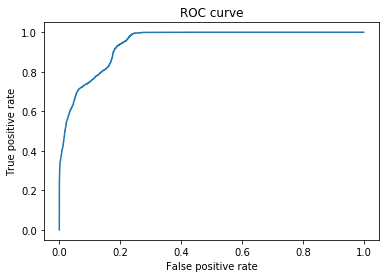

/Users/Theo/anaconda3/lib/python3.7/site-packages/sklearn/ensemble/iforest.py:417: DeprecationWarning:

threshold_ attribute is deprecated in 0.20 and will be removed in 0.22.

/Users/Theo/anaconda3/lib/python3.7/site-packages/sklearn/ensemble/iforest.py:417: DeprecationWarning:

threshold_ attribute is deprecated in 0.20 and will be removed in 0.22.

/Users/Theo/anaconda3/lib/python3.7/site-packages/sklearn/ensemble/iforest.py:213: FutureWarning:

default contamination parameter 0.1 will change in version 0.22 to "auto". This will change the predict method behavior.

/Users/Theo/anaconda3/lib/python3.7/site-packages/sklearn/ensemble/iforest.py:223: FutureWarning:

behaviour="old" is deprecated and will be removed in version 0.22. Please use behaviour="new", which makes the decision_function change to match other anomaly detection algorithm API.



f1_score= 0.506026862587533


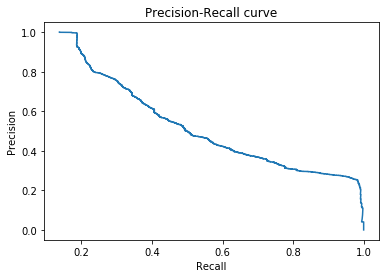

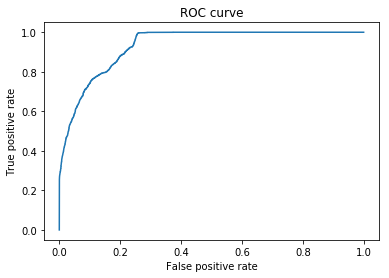

/Users/Theo/anaconda3/lib/python3.7/site-packages/sklearn/ensemble/iforest.py:417: DeprecationWarning:

threshold_ attribute is deprecated in 0.20 and will be removed in 0.22.

/Users/Theo/anaconda3/lib/python3.7/site-packages/sklearn/ensemble/iforest.py:417: DeprecationWarning:

threshold_ attribute is deprecated in 0.20 and will be removed in 0.22.

/Users/Theo/anaconda3/lib/python3.7/site-packages/sklearn/ensemble/iforest.py:213: FutureWarning:

default contamination parameter 0.1 will change in version 0.22 to "auto". This will change the predict method behavior.

/Users/Theo/anaconda3/lib/python3.7/site-packages/sklearn/ensemble/iforest.py:223: FutureWarning:

behaviour="old" is deprecated and will be removed in version 0.22. Please use behaviour="new", which makes the decision_function change to match other anomaly detection algorithm API.



f1_score= 0.6599473141679074


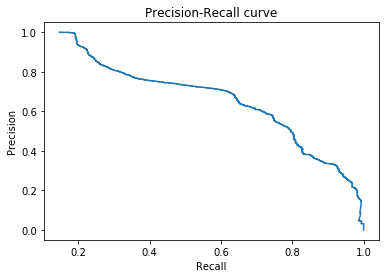

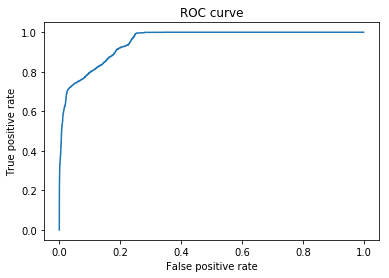

/Users/Theo/anaconda3/lib/python3.7/site-packages/sklearn/ensemble/iforest.py:417: DeprecationWarning:

threshold_ attribute is deprecated in 0.20 and will be removed in 0.22.

/Users/Theo/anaconda3/lib/python3.7/site-packages/sklearn/ensemble/iforest.py:417: DeprecationWarning:

threshold_ attribute is deprecated in 0.20 and will be removed in 0.22.

/Users/Theo/anaconda3/lib/python3.7/site-packages/sklearn/ensemble/iforest.py:213: FutureWarning:

default contamination parameter 0.1 will change in version 0.22 to "auto". This will change the predict method behavior.

/Users/Theo/anaconda3/lib/python3.7/site-packages/sklearn/ensemble/iforest.py:223: FutureWarning:

behaviour="old" is deprecated and will be removed in version 0.22. Please use behaviour="new", which makes the decision_function change to match other anomaly detection algorithm API.



f1_score= 0.6512040557667934


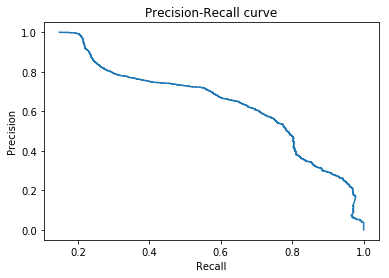

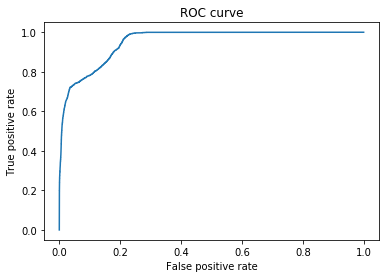

/Users/Theo/anaconda3/lib/python3.7/site-packages/sklearn/ensemble/iforest.py:417: DeprecationWarning:

threshold_ attribute is deprecated in 0.20 and will be removed in 0.22.

/Users/Theo/anaconda3/lib/python3.7/site-packages/sklearn/ensemble/iforest.py:417: DeprecationWarning:

threshold_ attribute is deprecated in 0.20 and will be removed in 0.22.

/Users/Theo/anaconda3/lib/python3.7/site-packages/sklearn/ensemble/iforest.py:213: FutureWarning:

default contamination parameter 0.1 will change in version 0.22 to "auto". This will change the predict method behavior.

/Users/Theo/anaconda3/lib/python3.7/site-packages/sklearn/ensemble/iforest.py:223: FutureWarning:

behaviour="old" is deprecated and will be removed in version 0.22. Please use behaviour="new", which makes the decision_function change to match other anomaly detection algorithm API.



f1_score= 0.6158865604216338


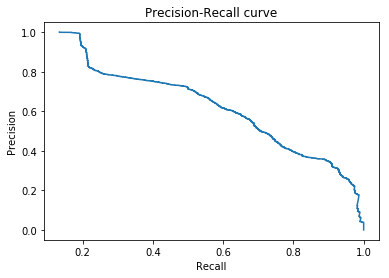

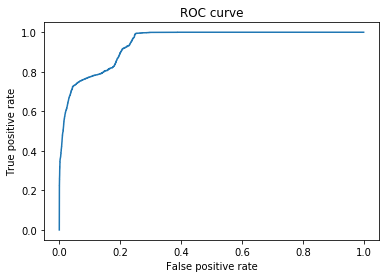

/Users/Theo/anaconda3/lib/python3.7/site-packages/sklearn/ensemble/iforest.py:417: DeprecationWarning:

threshold_ attribute is deprecated in 0.20 and will be removed in 0.22.

/Users/Theo/anaconda3/lib/python3.7/site-packages/sklearn/ensemble/iforest.py:417: DeprecationWarning:

threshold_ attribute is deprecated in 0.20 and will be removed in 0.22.

/Users/Theo/anaconda3/lib/python3.7/site-packages/sklearn/ensemble/iforest.py:213: FutureWarning:

default contamination parameter 0.1 will change in version 0.22 to "auto". This will change the predict method behavior.

/Users/Theo/anaconda3/lib/python3.7/site-packages/sklearn/ensemble/iforest.py:223: FutureWarning:

behaviour="old" is deprecated and will be removed in version 0.22. Please use behaviour="new", which makes the decision_function change to match other anomaly detection algorithm API.



f1_score= 0.40043684018929737


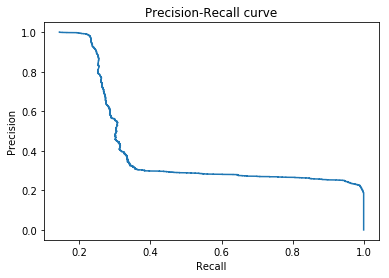

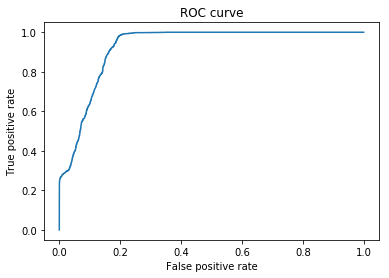

/Users/Theo/anaconda3/lib/python3.7/site-packages/sklearn/ensemble/iforest.py:417: DeprecationWarning:

threshold_ attribute is deprecated in 0.20 and will be removed in 0.22.

/Users/Theo/anaconda3/lib/python3.7/site-packages/sklearn/ensemble/iforest.py:417: DeprecationWarning:

threshold_ attribute is deprecated in 0.20 and will be removed in 0.22.

/Users/Theo/anaconda3/lib/python3.7/site-packages/sklearn/ensemble/iforest.py:213: FutureWarning:

default contamination parameter 0.1 will change in version 0.22 to "auto". This will change the predict method behavior.

/Users/Theo/anaconda3/lib/python3.7/site-packages/sklearn/ensemble/iforest.py:223: FutureWarning:

behaviour="old" is deprecated and will be removed in version 0.22. Please use behaviour="new", which makes the decision_function change to match other anomaly detection algorithm API.



f1_score= 0.529394299287411


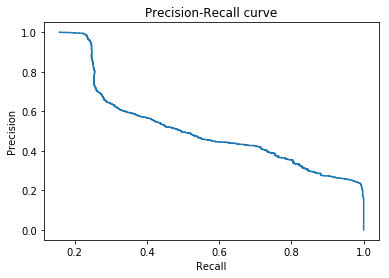

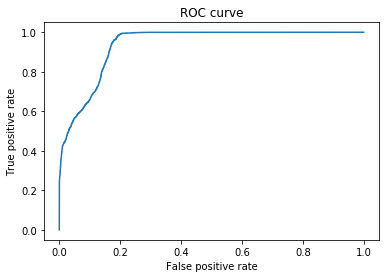

/Users/Theo/anaconda3/lib/python3.7/site-packages/sklearn/ensemble/iforest.py:417: DeprecationWarning:

threshold_ attribute is deprecated in 0.20 and will be removed in 0.22.

/Users/Theo/anaconda3/lib/python3.7/site-packages/sklearn/ensemble/iforest.py:417: DeprecationWarning:

threshold_ attribute is deprecated in 0.20 and will be removed in 0.22.

/Users/Theo/anaconda3/lib/python3.7/site-packages/sklearn/ensemble/iforest.py:213: FutureWarning:

default contamination parameter 0.1 will change in version 0.22 to "auto". This will change the predict method behavior.

/Users/Theo/anaconda3/lib/python3.7/site-packages/sklearn/ensemble/iforest.py:223: FutureWarning:

behaviour="old" is deprecated and will be removed in version 0.22. Please use behaviour="new", which makes the decision_function change to match other anomaly detection algorithm API.



f1_score= 0.5894279507603186


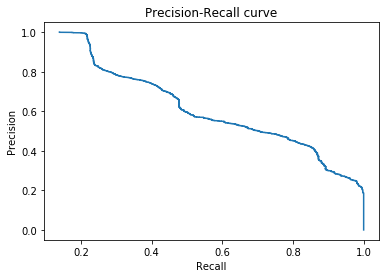

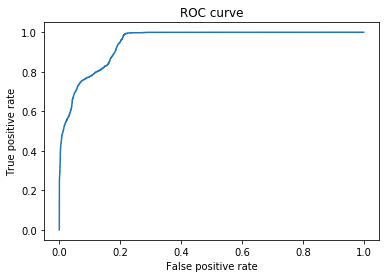

/Users/Theo/anaconda3/lib/python3.7/site-packages/sklearn/ensemble/iforest.py:417: DeprecationWarning:

threshold_ attribute is deprecated in 0.20 and will be removed in 0.22.

/Users/Theo/anaconda3/lib/python3.7/site-packages/sklearn/ensemble/iforest.py:417: DeprecationWarning:

threshold_ attribute is deprecated in 0.20 and will be removed in 0.22.

/Users/Theo/anaconda3/lib/python3.7/site-packages/sklearn/ensemble/iforest.py:213: FutureWarning:

default contamination parameter 0.1 will change in version 0.22 to "auto". This will change the predict method behavior.

/Users/Theo/anaconda3/lib/python3.7/site-packages/sklearn/ensemble/iforest.py:223: FutureWarning:

behaviour="old" is deprecated and will be removed in version 0.22. Please use behaviour="new", which makes the decision_function change to match other anomaly detection algorithm API.



f1_score= 0.6043312847527071


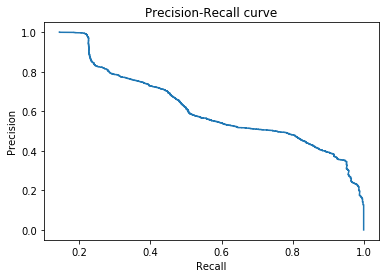

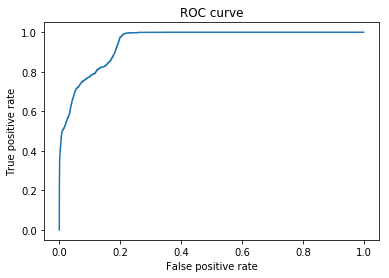

/Users/Theo/anaconda3/lib/python3.7/site-packages/sklearn/ensemble/iforest.py:417: DeprecationWarning:

threshold_ attribute is deprecated in 0.20 and will be removed in 0.22.

/Users/Theo/anaconda3/lib/python3.7/site-packages/sklearn/ensemble/iforest.py:417: DeprecationWarning:

threshold_ attribute is deprecated in 0.20 and will be removed in 0.22.

/Users/Theo/anaconda3/lib/python3.7/site-packages/sklearn/ensemble/iforest.py:213: FutureWarning:

default contamination parameter 0.1 will change in version 0.22 to "auto". This will change the predict method behavior.

/Users/Theo/anaconda3/lib/python3.7/site-packages/sklearn/ensemble/iforest.py:223: FutureWarning:

behaviour="old" is deprecated and will be removed in version 0.22. Please use behaviour="new", which makes the decision_function change to match other anomaly detection algorithm API.



f1_score= 0.6026865671641791


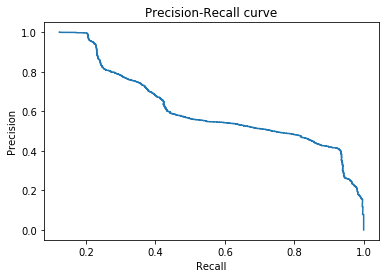

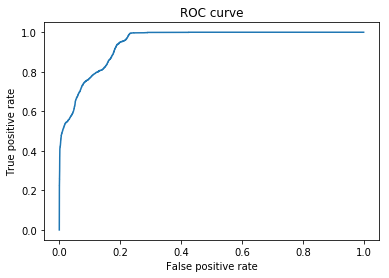

/Users/Theo/anaconda3/lib/python3.7/site-packages/sklearn/ensemble/iforest.py:417: DeprecationWarning:

threshold_ attribute is deprecated in 0.20 and will be removed in 0.22.

/Users/Theo/anaconda3/lib/python3.7/site-packages/sklearn/ensemble/iforest.py:417: DeprecationWarning:

threshold_ attribute is deprecated in 0.20 and will be removed in 0.22.

/Users/Theo/anaconda3/lib/python3.7/site-packages/sklearn/ensemble/iforest.py:213: FutureWarning:

default contamination parameter 0.1 will change in version 0.22 to "auto". This will change the predict method behavior.

/Users/Theo/anaconda3/lib/python3.7/site-packages/sklearn/ensemble/iforest.py:223: FutureWarning:

behaviour="old" is deprecated and will be removed in version 0.22. Please use behaviour="new", which makes the decision_function change to match other anomaly detection algorithm API.



f1_score= 0.6052037900436156


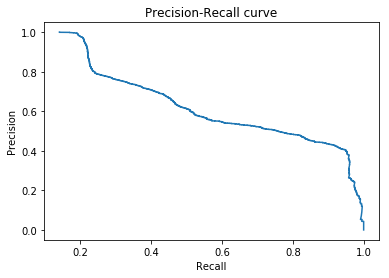

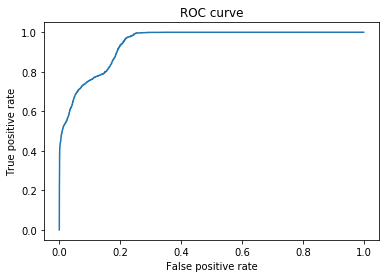

/Users/Theo/anaconda3/lib/python3.7/site-packages/sklearn/ensemble/iforest.py:417: DeprecationWarning:

threshold_ attribute is deprecated in 0.20 and will be removed in 0.22.

/Users/Theo/anaconda3/lib/python3.7/site-packages/sklearn/ensemble/iforest.py:417: DeprecationWarning:

threshold_ attribute is deprecated in 0.20 and will be removed in 0.22.

/Users/Theo/anaconda3/lib/python3.7/site-packages/sklearn/ensemble/iforest.py:213: FutureWarning:

default contamination parameter 0.1 will change in version 0.22 to "auto". This will change the predict method behavior.

/Users/Theo/anaconda3/lib/python3.7/site-packages/sklearn/ensemble/iforest.py:223: FutureWarning:

behaviour="old" is deprecated and will be removed in version 0.22. Please use behaviour="new", which makes the decision_function change to match other anomaly detection algorithm API.



f1_score= 0.6300610094287299


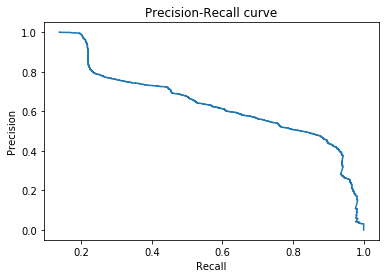

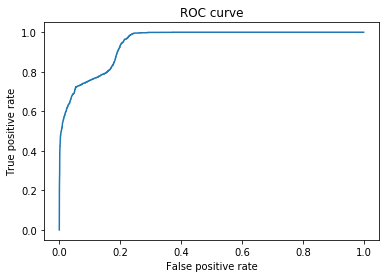

/Users/Theo/anaconda3/lib/python3.7/site-packages/sklearn/ensemble/iforest.py:417: DeprecationWarning:

threshold_ attribute is deprecated in 0.20 and will be removed in 0.22.

/Users/Theo/anaconda3/lib/python3.7/site-packages/sklearn/ensemble/iforest.py:417: DeprecationWarning:

threshold_ attribute is deprecated in 0.20 and will be removed in 0.22.

/Users/Theo/anaconda3/lib/python3.7/site-packages/sklearn/ensemble/iforest.py:213: FutureWarning:

default contamination parameter 0.1 will change in version 0.22 to "auto". This will change the predict method behavior.

/Users/Theo/anaconda3/lib/python3.7/site-packages/sklearn/ensemble/iforest.py:223: FutureWarning:

behaviour="old" is deprecated and will be removed in version 0.22. Please use behaviour="new", which makes the decision_function change to match other anomaly detection algorithm API.



f1_score= 0.632258064516129


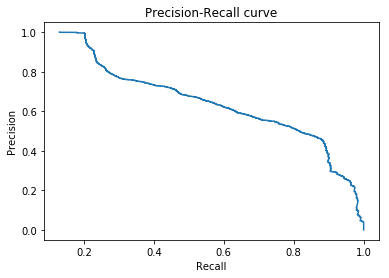

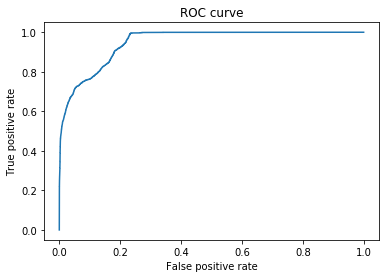

/Users/Theo/anaconda3/lib/python3.7/site-packages/sklearn/ensemble/iforest.py:417: DeprecationWarning:

threshold_ attribute is deprecated in 0.20 and will be removed in 0.22.

/Users/Theo/anaconda3/lib/python3.7/site-packages/sklearn/ensemble/iforest.py:417: DeprecationWarning:

threshold_ attribute is deprecated in 0.20 and will be removed in 0.22.

/Users/Theo/anaconda3/lib/python3.7/site-packages/sklearn/ensemble/iforest.py:213: FutureWarning:

default contamination parameter 0.1 will change in version 0.22 to "auto". This will change the predict method behavior.

/Users/Theo/anaconda3/lib/python3.7/site-packages/sklearn/ensemble/iforest.py:223: FutureWarning:

behaviour="old" is deprecated and will be removed in version 0.22. Please use behaviour="new", which makes the decision_function change to match other anomaly detection algorithm API.



f1_score= 0.6186750130412103


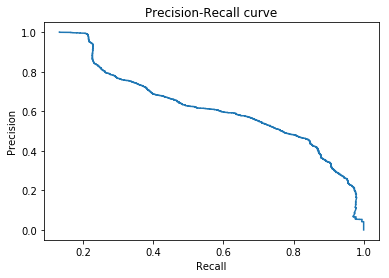

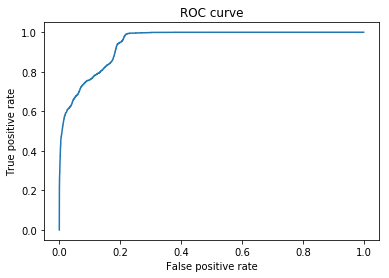

/Users/Theo/anaconda3/lib/python3.7/site-packages/sklearn/ensemble/iforest.py:417: DeprecationWarning:

threshold_ attribute is deprecated in 0.20 and will be removed in 0.22.

/Users/Theo/anaconda3/lib/python3.7/site-packages/sklearn/ensemble/iforest.py:417: DeprecationWarning:

threshold_ attribute is deprecated in 0.20 and will be removed in 0.22.

/Users/Theo/anaconda3/lib/python3.7/site-packages/sklearn/ensemble/iforest.py:213: FutureWarning:

default contamination parameter 0.1 will change in version 0.22 to "auto". This will change the predict method behavior.

/Users/Theo/anaconda3/lib/python3.7/site-packages/sklearn/ensemble/iforest.py:223: FutureWarning:

behaviour="old" is deprecated and will be removed in version 0.22. Please use behaviour="new", which makes the decision_function change to match other anomaly detection algorithm API.



f1_score= 0.6521441293327852


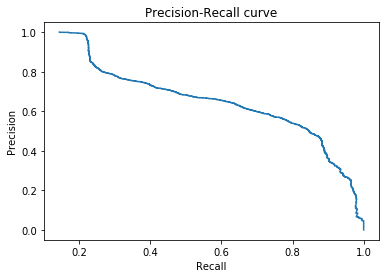

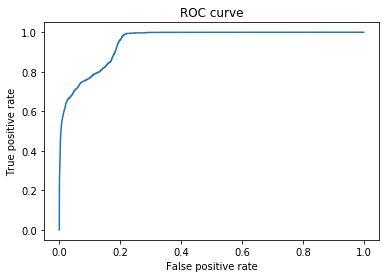

/Users/Theo/anaconda3/lib/python3.7/site-packages/sklearn/ensemble/iforest.py:417: DeprecationWarning:

threshold_ attribute is deprecated in 0.20 and will be removed in 0.22.

/Users/Theo/anaconda3/lib/python3.7/site-packages/sklearn/ensemble/iforest.py:417: DeprecationWarning:

threshold_ attribute is deprecated in 0.20 and will be removed in 0.22.

/Users/Theo/anaconda3/lib/python3.7/site-packages/sklearn/ensemble/iforest.py:213: FutureWarning:

default contamination parameter 0.1 will change in version 0.22 to "auto". This will change the predict method behavior.

/Users/Theo/anaconda3/lib/python3.7/site-packages/sklearn/ensemble/iforest.py:223: FutureWarning:

behaviour="old" is deprecated and will be removed in version 0.22. Please use behaviour="new", which makes the decision_function change to match other anomaly detection algorithm API.



f1_score= 0.3907791200265987


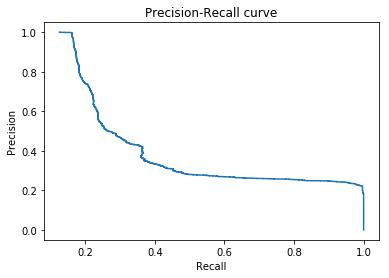

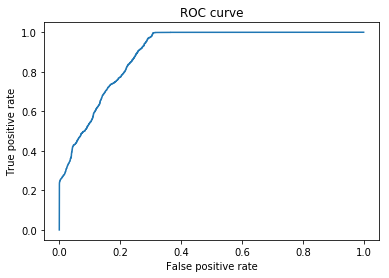

/Users/Theo/anaconda3/lib/python3.7/site-packages/sklearn/ensemble/iforest.py:417: DeprecationWarning:

threshold_ attribute is deprecated in 0.20 and will be removed in 0.22.

/Users/Theo/anaconda3/lib/python3.7/site-packages/sklearn/ensemble/iforest.py:417: DeprecationWarning:

threshold_ attribute is deprecated in 0.20 and will be removed in 0.22.

/Users/Theo/anaconda3/lib/python3.7/site-packages/sklearn/ensemble/iforest.py:213: FutureWarning:

default contamination parameter 0.1 will change in version 0.22 to "auto". This will change the predict method behavior.

/Users/Theo/anaconda3/lib/python3.7/site-packages/sklearn/ensemble/iforest.py:223: FutureWarning:

behaviour="old" is deprecated and will be removed in version 0.22. Please use behaviour="new", which makes the decision_function change to match other anomaly detection algorithm API.



f1_score= 0.5279267495094834


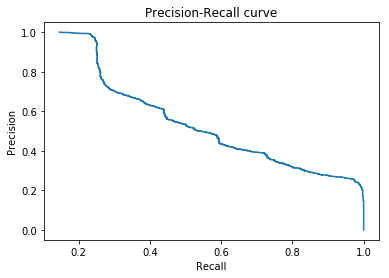

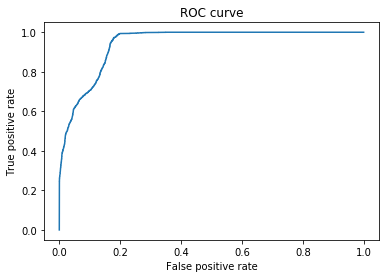

/Users/Theo/anaconda3/lib/python3.7/site-packages/sklearn/ensemble/iforest.py:417: DeprecationWarning:

threshold_ attribute is deprecated in 0.20 and will be removed in 0.22.

/Users/Theo/anaconda3/lib/python3.7/site-packages/sklearn/ensemble/iforest.py:417: DeprecationWarning:

threshold_ attribute is deprecated in 0.20 and will be removed in 0.22.

/Users/Theo/anaconda3/lib/python3.7/site-packages/sklearn/ensemble/iforest.py:213: FutureWarning:

default contamination parameter 0.1 will change in version 0.22 to "auto". This will change the predict method behavior.

/Users/Theo/anaconda3/lib/python3.7/site-packages/sklearn/ensemble/iforest.py:223: FutureWarning:

behaviour="old" is deprecated and will be removed in version 0.22. Please use behaviour="new", which makes the decision_function change to match other anomaly detection algorithm API.



f1_score= 0.5595870654319114


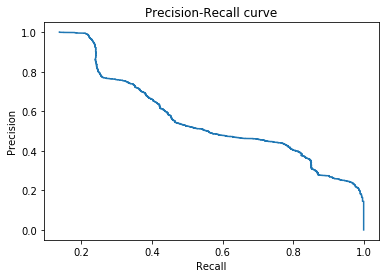

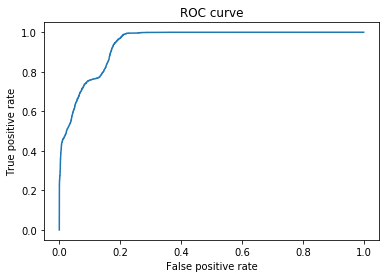

/Users/Theo/anaconda3/lib/python3.7/site-packages/sklearn/ensemble/iforest.py:417: DeprecationWarning:

threshold_ attribute is deprecated in 0.20 and will be removed in 0.22.

/Users/Theo/anaconda3/lib/python3.7/site-packages/sklearn/ensemble/iforest.py:417: DeprecationWarning:

threshold_ attribute is deprecated in 0.20 and will be removed in 0.22.

/Users/Theo/anaconda3/lib/python3.7/site-packages/sklearn/ensemble/iforest.py:213: FutureWarning:

default contamination parameter 0.1 will change in version 0.22 to "auto". This will change the predict method behavior.

/Users/Theo/anaconda3/lib/python3.7/site-packages/sklearn/ensemble/iforest.py:223: FutureWarning:

behaviour="old" is deprecated and will be removed in version 0.22. Please use behaviour="new", which makes the decision_function change to match other anomaly detection algorithm API.



f1_score= 0.5752265861027192


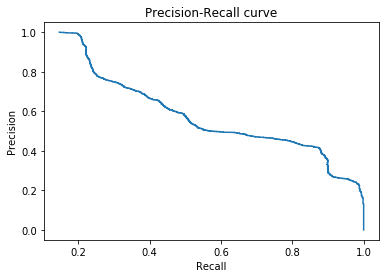

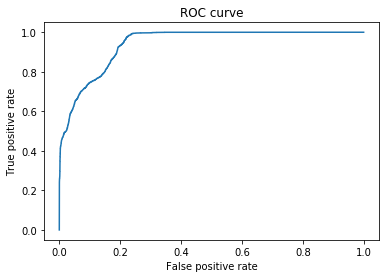

/Users/Theo/anaconda3/lib/python3.7/site-packages/sklearn/ensemble/iforest.py:417: DeprecationWarning:

threshold_ attribute is deprecated in 0.20 and will be removed in 0.22.

/Users/Theo/anaconda3/lib/python3.7/site-packages/sklearn/ensemble/iforest.py:417: DeprecationWarning:

threshold_ attribute is deprecated in 0.20 and will be removed in 0.22.

/Users/Theo/anaconda3/lib/python3.7/site-packages/sklearn/ensemble/iforest.py:213: FutureWarning:

default contamination parameter 0.1 will change in version 0.22 to "auto". This will change the predict method behavior.

/Users/Theo/anaconda3/lib/python3.7/site-packages/sklearn/ensemble/iforest.py:223: FutureWarning:

behaviour="old" is deprecated and will be removed in version 0.22. Please use behaviour="new", which makes the decision_function change to match other anomaly detection algorithm API.



f1_score= 0.5702629193109702


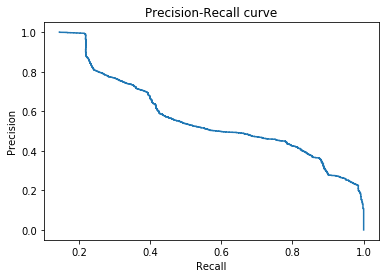

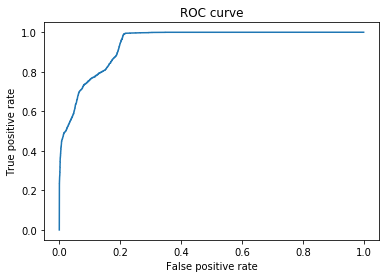

/Users/Theo/anaconda3/lib/python3.7/site-packages/sklearn/ensemble/iforest.py:417: DeprecationWarning:

threshold_ attribute is deprecated in 0.20 and will be removed in 0.22.

/Users/Theo/anaconda3/lib/python3.7/site-packages/sklearn/ensemble/iforest.py:417: DeprecationWarning:

threshold_ attribute is deprecated in 0.20 and will be removed in 0.22.

/Users/Theo/anaconda3/lib/python3.7/site-packages/sklearn/ensemble/iforest.py:213: FutureWarning:

default contamination parameter 0.1 will change in version 0.22 to "auto". This will change the predict method behavior.

/Users/Theo/anaconda3/lib/python3.7/site-packages/sklearn/ensemble/iforest.py:223: FutureWarning:

behaviour="old" is deprecated and will be removed in version 0.22. Please use behaviour="new", which makes the decision_function change to match other anomaly detection algorithm API.



f1_score= 0.5578231292517007


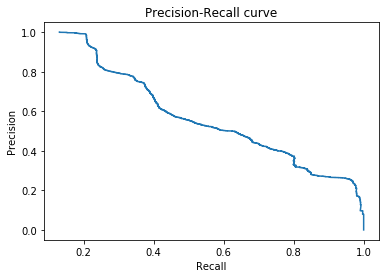

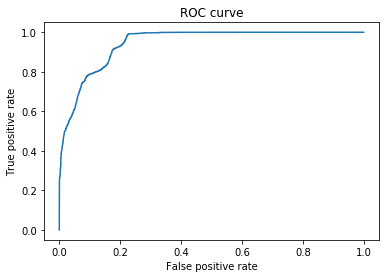

/Users/Theo/anaconda3/lib/python3.7/site-packages/sklearn/ensemble/iforest.py:417: DeprecationWarning:

threshold_ attribute is deprecated in 0.20 and will be removed in 0.22.

/Users/Theo/anaconda3/lib/python3.7/site-packages/sklearn/ensemble/iforest.py:417: DeprecationWarning:

threshold_ attribute is deprecated in 0.20 and will be removed in 0.22.

/Users/Theo/anaconda3/lib/python3.7/site-packages/sklearn/ensemble/iforest.py:213: FutureWarning:

default contamination parameter 0.1 will change in version 0.22 to "auto". This will change the predict method behavior.

/Users/Theo/anaconda3/lib/python3.7/site-packages/sklearn/ensemble/iforest.py:223: FutureWarning:

behaviour="old" is deprecated and will be removed in version 0.22. Please use behaviour="new", which makes the decision_function change to match other anomaly detection algorithm API.



f1_score= 0.5835004296763106


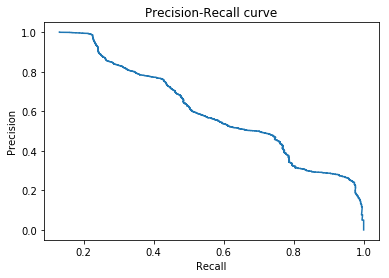

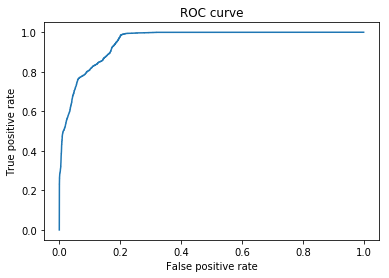

/Users/Theo/anaconda3/lib/python3.7/site-packages/sklearn/ensemble/iforest.py:417: DeprecationWarning:

threshold_ attribute is deprecated in 0.20 and will be removed in 0.22.

/Users/Theo/anaconda3/lib/python3.7/site-packages/sklearn/ensemble/iforest.py:417: DeprecationWarning:

threshold_ attribute is deprecated in 0.20 and will be removed in 0.22.

/Users/Theo/anaconda3/lib/python3.7/site-packages/sklearn/ensemble/iforest.py:213: FutureWarning:

default contamination parameter 0.1 will change in version 0.22 to "auto". This will change the predict method behavior.

/Users/Theo/anaconda3/lib/python3.7/site-packages/sklearn/ensemble/iforest.py:223: FutureWarning:

behaviour="old" is deprecated and will be removed in version 0.22. Please use behaviour="new", which makes the decision_function change to match other anomaly detection algorithm API.



f1_score= 0.5732592909013242


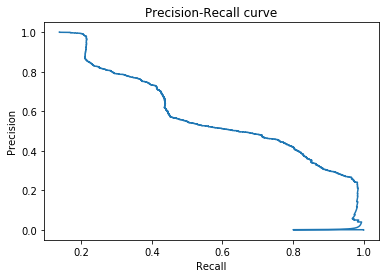

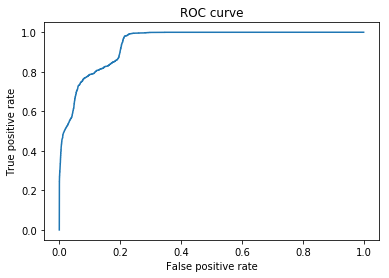

/Users/Theo/anaconda3/lib/python3.7/site-packages/sklearn/ensemble/iforest.py:417: DeprecationWarning:

threshold_ attribute is deprecated in 0.20 and will be removed in 0.22.

/Users/Theo/anaconda3/lib/python3.7/site-packages/sklearn/ensemble/iforest.py:417: DeprecationWarning:

threshold_ attribute is deprecated in 0.20 and will be removed in 0.22.

/Users/Theo/anaconda3/lib/python3.7/site-packages/sklearn/ensemble/iforest.py:213: FutureWarning:

default contamination parameter 0.1 will change in version 0.22 to "auto". This will change the predict method behavior.

/Users/Theo/anaconda3/lib/python3.7/site-packages/sklearn/ensemble/iforest.py:223: FutureWarning:

behaviour="old" is deprecated and will be removed in version 0.22. Please use behaviour="new", which makes the decision_function change to match other anomaly detection algorithm API.



f1_score= 0.6195060694851402


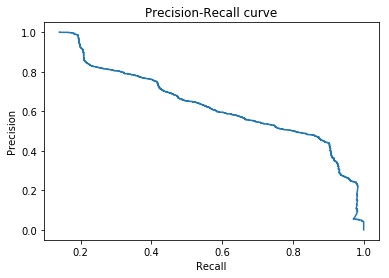

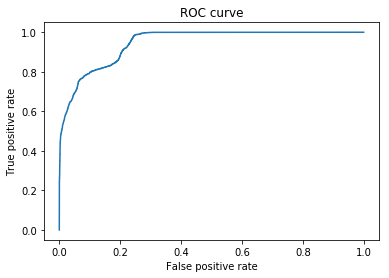

/Users/Theo/anaconda3/lib/python3.7/site-packages/sklearn/ensemble/iforest.py:417: DeprecationWarning:

threshold_ attribute is deprecated in 0.20 and will be removed in 0.22.

/Users/Theo/anaconda3/lib/python3.7/site-packages/sklearn/ensemble/iforest.py:417: DeprecationWarning:

threshold_ attribute is deprecated in 0.20 and will be removed in 0.22.

/Users/Theo/anaconda3/lib/python3.7/site-packages/sklearn/ensemble/iforest.py:213: FutureWarning:

default contamination parameter 0.1 will change in version 0.22 to "auto". This will change the predict method behavior.

/Users/Theo/anaconda3/lib/python3.7/site-packages/sklearn/ensemble/iforest.py:223: FutureWarning:

behaviour="old" is deprecated and will be removed in version 0.22. Please use behaviour="new", which makes the decision_function change to match other anomaly detection algorithm API.



f1_score= 0.640069384215091


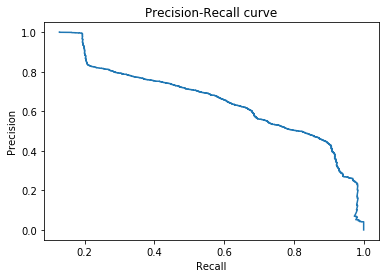

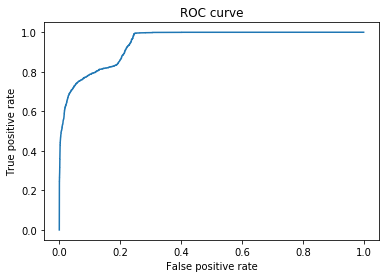

/Users/Theo/anaconda3/lib/python3.7/site-packages/sklearn/ensemble/iforest.py:417: DeprecationWarning:

threshold_ attribute is deprecated in 0.20 and will be removed in 0.22.

/Users/Theo/anaconda3/lib/python3.7/site-packages/sklearn/ensemble/iforest.py:417: DeprecationWarning:

threshold_ attribute is deprecated in 0.20 and will be removed in 0.22.

/Users/Theo/anaconda3/lib/python3.7/site-packages/sklearn/ensemble/iforest.py:213: FutureWarning:

default contamination parameter 0.1 will change in version 0.22 to "auto". This will change the predict method behavior.

/Users/Theo/anaconda3/lib/python3.7/site-packages/sklearn/ensemble/iforest.py:223: FutureWarning:

behaviour="old" is deprecated and will be removed in version 0.22. Please use behaviour="new", which makes the decision_function change to match other anomaly detection algorithm API.



f1_score= 0.4546271338724169


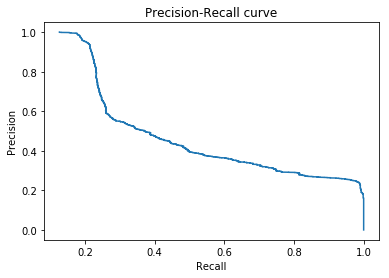

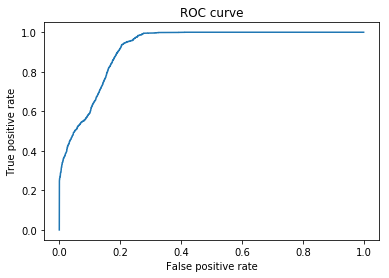

/Users/Theo/anaconda3/lib/python3.7/site-packages/sklearn/ensemble/iforest.py:417: DeprecationWarning:

threshold_ attribute is deprecated in 0.20 and will be removed in 0.22.

/Users/Theo/anaconda3/lib/python3.7/site-packages/sklearn/ensemble/iforest.py:417: DeprecationWarning:

threshold_ attribute is deprecated in 0.20 and will be removed in 0.22.

/Users/Theo/anaconda3/lib/python3.7/site-packages/sklearn/ensemble/iforest.py:213: FutureWarning:

default contamination parameter 0.1 will change in version 0.22 to "auto". This will change the predict method behavior.

/Users/Theo/anaconda3/lib/python3.7/site-packages/sklearn/ensemble/iforest.py:223: FutureWarning:

behaviour="old" is deprecated and will be removed in version 0.22. Please use behaviour="new", which makes the decision_function change to match other anomaly detection algorithm API.



f1_score= 0.5244174912224705


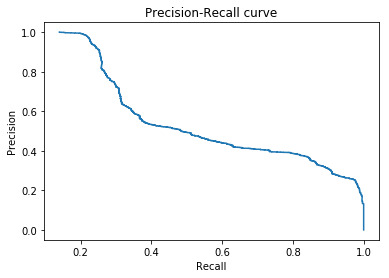

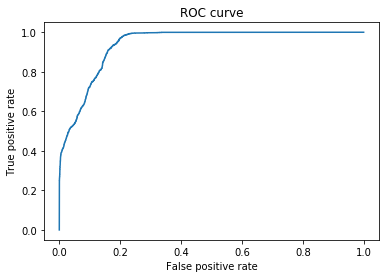

/Users/Theo/anaconda3/lib/python3.7/site-packages/sklearn/ensemble/iforest.py:417: DeprecationWarning:

threshold_ attribute is deprecated in 0.20 and will be removed in 0.22.

/Users/Theo/anaconda3/lib/python3.7/site-packages/sklearn/ensemble/iforest.py:417: DeprecationWarning:

threshold_ attribute is deprecated in 0.20 and will be removed in 0.22.

/Users/Theo/anaconda3/lib/python3.7/site-packages/sklearn/ensemble/iforest.py:213: FutureWarning:

default contamination parameter 0.1 will change in version 0.22 to "auto". This will change the predict method behavior.

/Users/Theo/anaconda3/lib/python3.7/site-packages/sklearn/ensemble/iforest.py:223: FutureWarning:

behaviour="old" is deprecated and will be removed in version 0.22. Please use behaviour="new", which makes the decision_function change to match other anomaly detection algorithm API.



f1_score= 0.5204734049789145


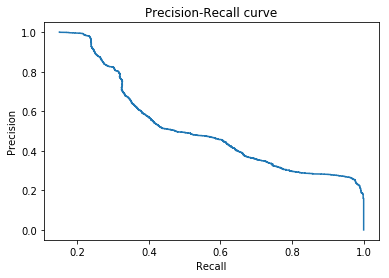

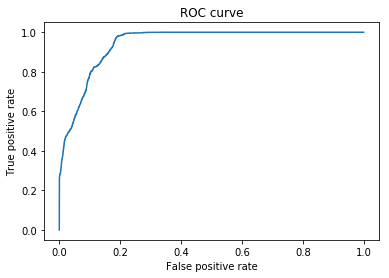

/Users/Theo/anaconda3/lib/python3.7/site-packages/sklearn/ensemble/iforest.py:417: DeprecationWarning:

threshold_ attribute is deprecated in 0.20 and will be removed in 0.22.

/Users/Theo/anaconda3/lib/python3.7/site-packages/sklearn/ensemble/iforest.py:417: DeprecationWarning:

threshold_ attribute is deprecated in 0.20 and will be removed in 0.22.

/Users/Theo/anaconda3/lib/python3.7/site-packages/sklearn/ensemble/iforest.py:213: FutureWarning:

default contamination parameter 0.1 will change in version 0.22 to "auto". This will change the predict method behavior.

/Users/Theo/anaconda3/lib/python3.7/site-packages/sklearn/ensemble/iforest.py:223: FutureWarning:

behaviour="old" is deprecated and will be removed in version 0.22. Please use behaviour="new", which makes the decision_function change to match other anomaly detection algorithm API.



f1_score= 0.4946901465250706


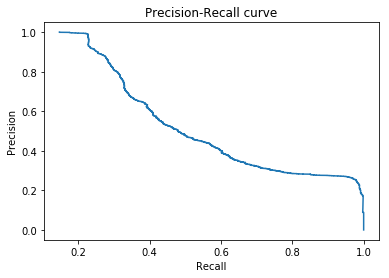

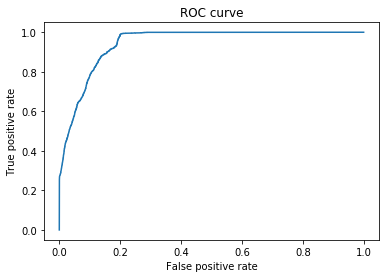

/Users/Theo/anaconda3/lib/python3.7/site-packages/sklearn/ensemble/iforest.py:417: DeprecationWarning:

threshold_ attribute is deprecated in 0.20 and will be removed in 0.22.

/Users/Theo/anaconda3/lib/python3.7/site-packages/sklearn/ensemble/iforest.py:417: DeprecationWarning:

threshold_ attribute is deprecated in 0.20 and will be removed in 0.22.

/Users/Theo/anaconda3/lib/python3.7/site-packages/sklearn/ensemble/iforest.py:213: FutureWarning:

default contamination parameter 0.1 will change in version 0.22 to "auto". This will change the predict method behavior.

/Users/Theo/anaconda3/lib/python3.7/site-packages/sklearn/ensemble/iforest.py:223: FutureWarning:

behaviour="old" is deprecated and will be removed in version 0.22. Please use behaviour="new", which makes the decision_function change to match other anomaly detection algorithm API.



f1_score= 0.5622133027522936


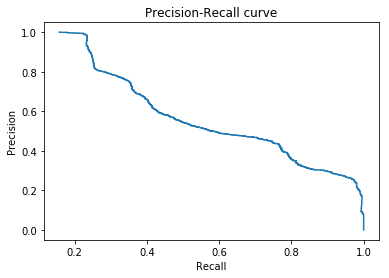

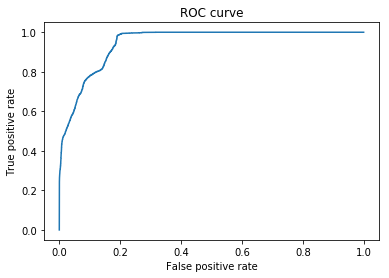

/Users/Theo/anaconda3/lib/python3.7/site-packages/sklearn/ensemble/iforest.py:417: DeprecationWarning:

threshold_ attribute is deprecated in 0.20 and will be removed in 0.22.

/Users/Theo/anaconda3/lib/python3.7/site-packages/sklearn/ensemble/iforest.py:417: DeprecationWarning:

threshold_ attribute is deprecated in 0.20 and will be removed in 0.22.

/Users/Theo/anaconda3/lib/python3.7/site-packages/sklearn/ensemble/iforest.py:213: FutureWarning:

default contamination parameter 0.1 will change in version 0.22 to "auto". This will change the predict method behavior.

/Users/Theo/anaconda3/lib/python3.7/site-packages/sklearn/ensemble/iforest.py:223: FutureWarning:

behaviour="old" is deprecated and will be removed in version 0.22. Please use behaviour="new", which makes the decision_function change to match other anomaly detection algorithm API.



f1_score= 0.5519326279421292


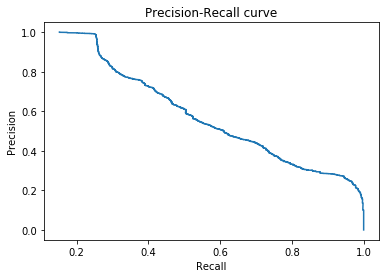

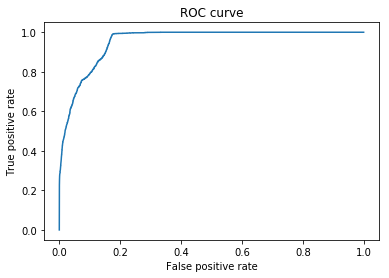

/Users/Theo/anaconda3/lib/python3.7/site-packages/sklearn/ensemble/iforest.py:417: DeprecationWarning:

threshold_ attribute is deprecated in 0.20 and will be removed in 0.22.

/Users/Theo/anaconda3/lib/python3.7/site-packages/sklearn/ensemble/iforest.py:417: DeprecationWarning:

threshold_ attribute is deprecated in 0.20 and will be removed in 0.22.

/Users/Theo/anaconda3/lib/python3.7/site-packages/sklearn/ensemble/iforest.py:213: FutureWarning:

default contamination parameter 0.1 will change in version 0.22 to "auto". This will change the predict method behavior.

/Users/Theo/anaconda3/lib/python3.7/site-packages/sklearn/ensemble/iforest.py:223: FutureWarning:

behaviour="old" is deprecated and will be removed in version 0.22. Please use behaviour="new", which makes the decision_function change to match other anomaly detection algorithm API.



f1_score= 0.5456686731222192


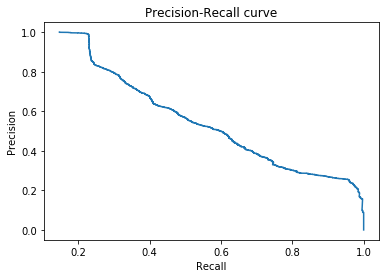

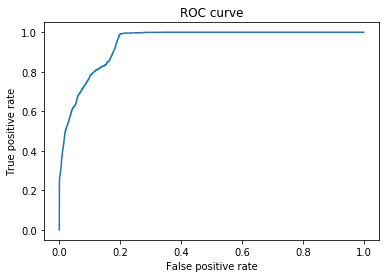

/Users/Theo/anaconda3/lib/python3.7/site-packages/sklearn/ensemble/iforest.py:417: DeprecationWarning:

threshold_ attribute is deprecated in 0.20 and will be removed in 0.22.

/Users/Theo/anaconda3/lib/python3.7/site-packages/sklearn/ensemble/iforest.py:417: DeprecationWarning:

threshold_ attribute is deprecated in 0.20 and will be removed in 0.22.

/Users/Theo/anaconda3/lib/python3.7/site-packages/sklearn/ensemble/iforest.py:213: FutureWarning:

default contamination parameter 0.1 will change in version 0.22 to "auto". This will change the predict method behavior.

/Users/Theo/anaconda3/lib/python3.7/site-packages/sklearn/ensemble/iforest.py:223: FutureWarning:

behaviour="old" is deprecated and will be removed in version 0.22. Please use behaviour="new", which makes the decision_function change to match other anomaly detection algorithm API.



f1_score= 0.5209707201266156


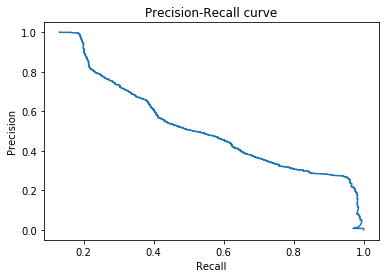

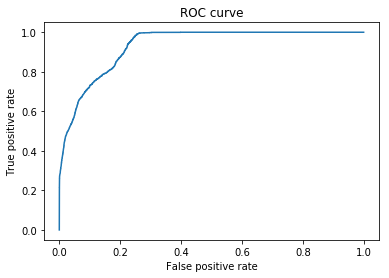

/Users/Theo/anaconda3/lib/python3.7/site-packages/sklearn/ensemble/iforest.py:417: DeprecationWarning:

threshold_ attribute is deprecated in 0.20 and will be removed in 0.22.

/Users/Theo/anaconda3/lib/python3.7/site-packages/sklearn/ensemble/iforest.py:417: DeprecationWarning:

threshold_ attribute is deprecated in 0.20 and will be removed in 0.22.

/Users/Theo/anaconda3/lib/python3.7/site-packages/sklearn/ensemble/iforest.py:213: FutureWarning:

default contamination parameter 0.1 will change in version 0.22 to "auto". This will change the predict method behavior.

/Users/Theo/anaconda3/lib/python3.7/site-packages/sklearn/ensemble/iforest.py:223: FutureWarning:

behaviour="old" is deprecated and will be removed in version 0.22. Please use behaviour="new", which makes the decision_function change to match other anomaly detection algorithm API.

/Users/Theo/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:16: RuntimeWarning:

divide by zero encountered in true_divide

/User

f1_score= 0.5564639046695302


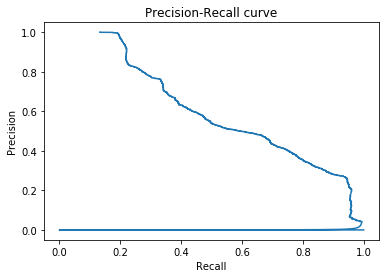

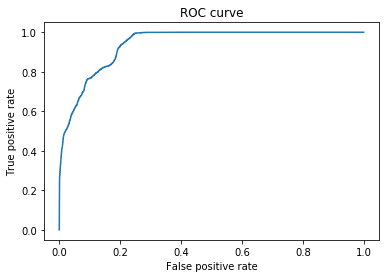

/Users/Theo/anaconda3/lib/python3.7/site-packages/sklearn/ensemble/iforest.py:417: DeprecationWarning:

threshold_ attribute is deprecated in 0.20 and will be removed in 0.22.

/Users/Theo/anaconda3/lib/python3.7/site-packages/sklearn/ensemble/iforest.py:417: DeprecationWarning:

threshold_ attribute is deprecated in 0.20 and will be removed in 0.22.

/Users/Theo/anaconda3/lib/python3.7/site-packages/sklearn/ensemble/iforest.py:213: FutureWarning:

default contamination parameter 0.1 will change in version 0.22 to "auto". This will change the predict method behavior.

/Users/Theo/anaconda3/lib/python3.7/site-packages/sklearn/ensemble/iforest.py:223: FutureWarning:

behaviour="old" is deprecated and will be removed in version 0.22. Please use behaviour="new", which makes the decision_function change to match other anomaly detection algorithm API.



f1_score= 0.5378435517970402


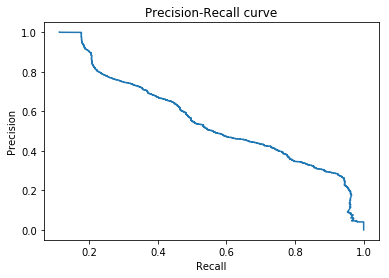

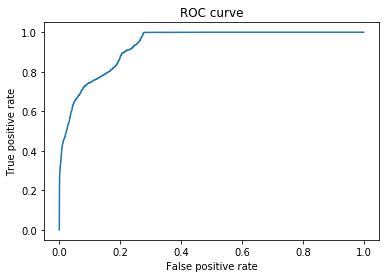

/Users/Theo/anaconda3/lib/python3.7/site-packages/sklearn/ensemble/iforest.py:417: DeprecationWarning:

threshold_ attribute is deprecated in 0.20 and will be removed in 0.22.

/Users/Theo/anaconda3/lib/python3.7/site-packages/sklearn/ensemble/iforest.py:417: DeprecationWarning:

threshold_ attribute is deprecated in 0.20 and will be removed in 0.22.



0.693446088794926
400
800


In [3]:
# MODEL BUILDING
imax=0
jmax=0
f1_max=0
for i in range(100,1001,100):
    for j in range(100, 1001, 100):
        rng = np.random.RandomState(i)
        

        # training the model
        clf = IsolationForest(max_samples=j, random_state=rng)
        clf.fit(X_train)
        score = -clf.score_samples(X_train)
        # Precision recall curve
        precision, recall, thresholds = precision_recall_curve(ylabel_train, score)
        f1_score = 2*precision*recall/(precision+recall)
        meilleur_f1_score = max(f1_score)
        # ROC curve
        fpr, tpr, thresholds = roc_curve(ylabel_train, score)

        #position = f1_score.index(meilleur_f1_score)
        #threshold_corres = thresholds[position]
        print("f1_score=",meilleur_f1_score)
        #print("threshold=", threshold_corres)
        #PLOT precision recall curve
        plt.plot(precision, recall)
        plt.xlabel('Recall')
        plt.ylabel('Precision')
        plt.title('Precision-Recall curve')
        plt.show()
        
        #PLOT roc curve
        plt.plot(fpr, tpr)
        plt.xlabel('False positive rate')
        plt.ylabel('True positive rate')
        plt.title('ROC curve')
        plt.show()
        
        # predictions
        y_pred_train = clf.predict(X_train)
        y_pred_test = clf.predict(X_test)
        # y_pred_outliers = clf.predict(X_outliers)
        # Meilleurs paramètres
        if meilleur_f1_score>f1_max:
            f1_max=meilleur_f1_score
            imax=i
            jmax=j
            
print(f1_max)
print(imax)
print(jmax)
        
        

In [ ]:
# EVALUATION

#print("Accuracy on train set: ", list(y_pred_train).count(1)/y_pred_train.shape[0])

#print("Accuracy on test set: ", list(y_pred_test).count(1)/y_pred_test.shape[0])


